# Data Download

In [0]:
!ls

sample_data  ser_humelo_dataset


In [1]:
import torch
torch.__version__

'1.1.0'

In [0]:
!wget http://yanran.li/files/ijcnlp_dailydialog.zip

--2019-04-28 18:24:28--  http://yanran.li/files/ijcnlp_dailydialog.zip
Resolving yanran.li (yanran.li)... 207.97.227.245, 192.30.252.154, 192.30.252.153
Connecting to yanran.li (yanran.li)|207.97.227.245|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2019-04-28 18:24:28 ERROR 404: Not Found.



In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

KeyboardInterrupt: ignored

In [0]:
!unzip ijcnlp_dailydialog.zip
!unzip ijcnlp_dailydialog/train.zip
!unzip ijcnlp_dailydialog/test.zip
!mkdir checkpoints
!git clone https://github.com/guxd/DialogWAE

unzip:  cannot find or open ijcnlp_dailydialog.zip, ijcnlp_dailydialog.zip.zip or ijcnlp_dailydialog.zip.ZIP.
unzip:  cannot find or open ijcnlp_dailydialog/train.zip, ijcnlp_dailydialog/train.zip.zip or ijcnlp_dailydialog/train.zip.ZIP.
unzip:  cannot find or open ijcnlp_dailydialog/test.zip, ijcnlp_dailydialog/test.zip.zip or ijcnlp_dailydialog/test.zip.ZIP.
Cloning into 'DialogWAE'...
remote: Enumerating objects: 64, done.
remote: Total 64 (delta 0), reused 0 (delta 0), pack-reused 64
Unpacking objects: 100% (64/64), done.


In [0]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip glove.twitter.27B.200d.txt

--2019-04-28 18:24:45--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2019-04-28 18:24:46--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  3.46MB/s    in 5m 49s  

2019-04-28 18:30:34 (4.16 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.200d.txt  


# Setup

In [0]:
import torch
import torch.nn.functional as F
import nltk
import numpy as np
from torch import nn, optim, autograd
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import wordpunct_tokenize
import matplotlib.pyplot as plt
from shutil import copyfile
from collections import Counter
from DialogWAE.experiments import Metrics


EMBEDDING = 200
GRU_DIM = 300
LATENT_DIM = 200
FC_DIM = 200
FC_DIM_D = 400
INIT_SCALE = 0.02
VOCAB_SIZE = 10000
MAX_UTT = 40
MAX_CONTEXT = 10
LR_GEN = 5e-5
LR_RECON = 1.0
LR_DISC = 1e-5
LAMBDA_D = 10
N_CRITIC = 5
MAX_NORM = 1.0

def to_string(x):
    assert type(x) == list
    return " ".join(x)

def mean(x):
    assert type(x) == list
    return sum(x)/len(x)

# Data Preprocessing


In [0]:
class MyDataset(Dataset):
    PAD = 0
    SOS = 1
    EOS = 2
    UNK = 3
    SOD = 4
    vocab_counter = 5

    def __init__(self, source_file, vocab = None):
        self.vocab = vocab
        dataset, self.vocab = self.init_dataset(source_file)
        
        inputs = list()
        targets = list()
        for entry in dataset:
            entry = self.to_num(entry)
            for i in range(2, len(entry)):
                if(i > MAX_CONTEXT):
                    offset = i - MAX_CONTEXT
                else:
                    offset = 0
            inputs.append(entry[offset:i])
            targets.append(entry[i])
        self.inputs = inputs
        self.targets = targets
        
    def init_dataset(self, source_file):
        c = Counter()
        dataset = []
        with open(source_file, 'r') as f:
            for dialog in f:
                dialog = [wordpunct_tokenize(u.strip(" ").lower()) for u in dialog.strip("__eou__\n").split("__eou__")]
                dataset.append(dialog)
                for utt in dialog:
                    c.update(utt)
        
        if self.vocab:
            vocab = self.vocab
        else:
            vocab = dict()
            vocab['num_to_word'] = dict()
            vocab['word_to_num'] = dict()
            vocab['num_to_word'][self.PAD] = 'pad'
            vocab['num_to_word'][self.SOS] = 'sos'
            vocab['num_to_word'][self.EOS] = 'eos'
            vocab['num_to_word'][self.UNK] = 'unk'
            vocab['num_to_word'][self.SOD] = 'sod'
            vocab['word_to_num']['pad'] = 0
            vocab['word_to_num']['sos'] = 1
            vocab['word_to_num']['eos'] = 2
            vocab['word_to_num']['unk'] = 3
            vocab['word_to_num']['sod'] = 4


            for k,_ in c.most_common(VOCAB_SIZE-self.vocab_counter):
                vocab['word_to_num'][k] = self.vocab_counter
                vocab['num_to_word'][self.vocab_counter] = k
                self.vocab_counter += 1
            
        return dataset, vocab
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
    
    def to_num(self, dialog):
        new_dialog = list()
        new_dialog.append([self.SOS, self.SOD, self.EOS])
        for i, utt in enumerate(dialog):
            new_utt = list()
            new_utt.append(self.SOS)
            for j, word in enumerate(utt):
                if j == MAX_UTT - 2:
                    break;
                if word in self.vocab['word_to_num']:
                    new_utt.append(self.vocab['word_to_num'][word])
                else:
                    new_utt.append(self.UNK)
            new_utt.append(self.EOS)
            new_dialog.append(new_utt)
        return new_dialog
    
    def to_text(self, utt):
        text = []
        for num in utt:
            if num == self.PAD:
                break
            text.append(self.vocab["num_to_word"][num])
        return text
    
    def padded(self, utt, max_len = MAX_UTT):
        return utt + [self.PAD] * (max_len - len(utt))

    def collector(self, samples):
        X = list()
        Y = list()
        for context, target in samples:
            X.append(context)
            Y.append(target)
        max_context = max([len(c) for c in X])
        for i in range(len(X)):
            X[i] += [[]] * (max_context - len(X[i]))
        Xlen = list()
        for context in X:
            Xlen += [len(utt) for utt in context]

        max_utt = max(Xlen)
        for i in range(len(X)):
            for j in range(len(X[i])):
                X[i][j] = self.padded(X[i][j], max_utt)

        Ylen = [len(utt) for utt in Y]
        max_target = max(Ylen)

        for i in range(len(Y)):
            Y[i] = self.padded(Y[i], max_target)

        return torch.tensor(X), torch.tensor(Xlen), torch.tensor(Y), torch.tensor(Ylen)

# Model

In [0]:
class PriorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.core = nn.Sequential(nn.Linear(GRU_DIM, FC_DIM),
                                  nn.BatchNorm1d(FC_DIM),
                                  nn.Tanh(),
                                  nn.Linear(FC_DIM, FC_DIM),
                                  nn.BatchNorm1d(FC_DIM),
                                  nn.Tanh())
        self.mu_layer = nn.Linear(FC_DIM, FC_DIM)
        self.logvar_layer = nn.Linear(FC_DIM, FC_DIM)
        
    def forward(self, x):
        h = self.core(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar
        
class RecognitionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.core = nn.Sequential(nn.Linear(3*GRU_DIM, FC_DIM),
                                  nn.BatchNorm1d(FC_DIM),
                                  nn.Tanh(),
                                  nn.Linear(FC_DIM, FC_DIM),
                                  nn.BatchNorm1d(FC_DIM),
                                  nn.Tanh())
        self.mu_layer = nn.Linear(FC_DIM, FC_DIM)
        self.logvar_layer = nn.Linear(FC_DIM, FC_DIM)
        
    def forward(self, x):
        h = self.core(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

class DialogWAE(nn.Module):
    def __init__(self, train_dir, test_dir, word2vec_dir,
                 batch_size, device):
        super().__init__()
        self.batch_size = batch_size
        self.epoch = 1
        self.device = device
        
        self.data = MyDataset(train_dir)
        self.test_data = MyDataset(test_dir, self.data.vocab)
        
        self.test_data_loader = DataLoader(self.test_data, 1, shuffle=True,
                                           collate_fn = self.data.collector)
        
        self.data_loader = DataLoader(self.data, self.batch_size, shuffle=True, 
                                      collate_fn = self.data.collector)
        
        self.embedding = self.init_word2vec(word2vec_dir)
        self.metrics = Metrics(self.embedding.weight.data.numpy())
        
        self.UEnc = nn.GRU(EMBEDDING, GRU_DIM,
                           bidirectional=True, 
                           batch_first = True)
        
        self.CEnc = nn.GRU(GRU_DIM*2 + 2, GRU_DIM,
                           batch_first = True)
        
        self.Q = nn.Sequential(nn.Linear(FC_DIM, FC_DIM),
                               nn.BatchNorm1d(FC_DIM),
                               nn.ReLU(),
                               nn.Linear(FC_DIM, FC_DIM),
                               nn.BatchNorm1d(FC_DIM),
                               nn.ReLU(),
                               nn.Linear(FC_DIM, LATENT_DIM))
        
        self.G = nn.Sequential(nn.Linear(FC_DIM, FC_DIM),
                               nn.BatchNorm1d(FC_DIM),
                               nn.ReLU(),
                               nn.Linear(FC_DIM, FC_DIM),
                               nn.BatchNorm1d(FC_DIM),
                               nn.ReLU(),
                               nn.Linear(FC_DIM, LATENT_DIM))
        
        self.D = nn.Sequential(nn.Linear(FC_DIM + GRU_DIM, FC_DIM_D),
                               nn.BatchNorm1d(FC_DIM_D),
#                              nn.ReLU(),
                               nn.LeakyReLU(0.2),
                               nn.Linear(FC_DIM_D, FC_DIM_D),
                               nn.BatchNorm1d(FC_DIM_D),
                               nn.LeakyReLU(0.2),
#                              nn.ReLU(),
                               nn.Linear(FC_DIM_D, 1))
        self.PriNet = PriorNet()
        self.RecNet = RecognitionNet()
        self.Dec = nn.GRU(EMBEDDING, LATENT_DIM + GRU_DIM,
                          batch_first = True)
        self.dec_projector = nn.Linear(LATENT_DIM + GRU_DIM, VOCAB_SIZE)
        self.init_weights()
        nn.init.uniform_(self.dec_projector.weight, -0.1, 0.1)

        self.optimizer_gen = optim.RMSprop(list(self.Q.parameters()) \
                                           +list(self.G.parameters()) \
                                           +list(self.PriNet.parameters()) \
                                           +list(self.RecNet.parameters()), LR_GEN)
        
        self.optimizer_discriminator = optim.RMSprop(self.D.parameters(), LR_DISC)
        
        self.encoder = nn.ModuleList([self.embedding,
                                 self.UEnc,
                                 self.CEnc])
        self.decoder = nn.ModuleList([self.embedding,
                                 self.Dec,
                                 self.dec_projector])
        
        self.optimizer_reconstruction = optim.SGD(list(self.encoder.parameters()) \
                                                  +list(self.RecNet.parameters()) \
                                                  +list(self.Q.parameters()) \
                                                  +list(self.decoder.parameters()),
                                                  LR_RECON)
        self.lr_decay = optim.lr_scheduler.StepLR(self.optimizer_reconstruction,
                                                  10, 0.6)


        
    def init_weights(self):
        for layer in self.modules():
            if type(layer) == nn.Linear:
                nn.init.uniform_(layer.weight, -INIT_SCALE, INIT_SCALE)
                layer.bias.data.fill_(0)
            elif type(layer) == nn.GRU:
                for w in layer.parameters(): 
                    if w.dim()>1:
                        nn.init.orthogonal_(w)
    
    def init_word2vec(self, word2vec_dir):
        if word2vec_dir:
            SIZE = 1.2 * 10**6
            found = 0
            word2vec_pretrained = torch.randn(VOCAB_SIZE,200)
            word2vec_pretrained[self.data.PAD] = torch.zeros(200)
            with open(word2vec_dir, 'r') as f:
                for entry in f:
                    entry = entry.strip().split(" ")
                    if entry[0] in self.data.vocab['word_to_num']:
                        idx = self.data.vocab['word_to_num'][entry[0]]
                        word2vec_pretrained[idx] = torch.tensor(list(map(float, entry[1:])))
                        found += 1
                    if found == VOCAB_SIZE:
                        break
                print("Done Initializing Word2Vec (found %d/%d)" %(found, VOCAB_SIZE))
            return nn.Embedding.from_pretrained(word2vec_pretrained, freeze=False)
        else:
            return nn.Embedding(VOCAB_SIZE, 200, padding_idx = self.data.PAD)

    def forward(self, X, Xlen):
        c = self.encode_c(X, Xlen)

        eps_prior = self.sample_prior(c)
        z_prior = self.G(eps_prior)
        
        init_state = torch.unsqueeze(torch.cat((z_prior, c), 1), 0)
            
        return self.decode(None, init_state)
        
        
    
    def discriminator_loss(self, z_prior, z_posterior, c):
        prior_input = torch.cat((z_prior, c), -1)
        posterior_input = torch.cat((z_posterior, c), -1)
        
        d_prior = self.D(prior_input)
        d_posterior = self.D(posterior_input)
        
        loss = torch.mean(d_posterior) - torch.mean(d_prior)
        return loss
    
    def gradient_penalty(self, z_prior, z_posterior, c):
        batch_size = c.size(0)
        alpha = torch.rand((batch_size, 1)).to(self.device)
        
        alpha = alpha.expand(z_prior.size())
        interpolates = alpha * z_prior.data + (1-alpha) * z_posterior.data
        interpolates.requires_grad = True
        
        d_interpolates = torch.mean(self.D(torch.cat((interpolates, c), -1)))
        
        grad_outputs = torch.FloatTensor([1]).to(device)
        grad = autograd.grad(d_interpolates, interpolates,
                            grad_outputs = grad_outputs,
                            only_inputs = True, create_graph = True,
                            retain_graph=True)[0]
        grad_norm = torch.norm(grad, p = 2, dim = 1)
        
        penalty = (grad_norm - 1) ** 2
        return torch.mean(penalty)
    
    def reconstruction_loss(self, pred, target):
        target = target.contiguous().view(-1)
        mask = [idx for idx, val in enumerate(target) if val != self.data.PAD]
        mask = torch.tensor(mask).to(self.device)
        pred = F.log_softmax(pred, -1).view(-1, VOCAB_SIZE)
        pred = torch.index_select(pred, 0, mask)
        target = torch.index_select(target, 0, mask)
        loss = F.nll_loss(pred, target)
        return loss
    
    def combine_context(self, X, lengths, X_raw):
        batch_size = len(lengths)
        context_window = max(lengths)
        LISTENER_VECTOR = [1,0]
        SPEAKER_VECTOR = [0,1]
        speaker_first = [SPEAKER_VECTOR if i%2==0 else LISTENER_VECTOR
                         for i in range(context_window)]
        listener_first = [LISTENER_VECTOR if i%2==0 else SPEAKER_VECTOR
                          for i in range(context_window)]
        floors = []        
        new_X = list()
        offset = 0
        for length in lengths:
            segment = X[offset:offset+length]
            floor = speaker_first if length%2==0 else listener_first
            if X_raw[offset][1] == self.data.SOD:
                floor[0] = LISTENER_VECTOR
            floors.append(floor)
            segment_len, dim = segment.shape
            segment_padded = torch.cat((segment,
                                      torch.randn(context_window - segment_len, dim)\
                                        .to(self.device)))
            new_X.append(segment_padded)
            offset += length
        X = torch.stack(new_X, 0)
        floors = torch.tensor(floors, dtype=torch.float).to(self.device)
        
        return torch.cat((X, floors), 2)
        
    def encode_x(self, Y, Ylen):
        Ylen_sorted, ids = torch.sort(Ylen, descending=True)
        _, ids_reverse = torch.sort(ids, descending=False)
        Y_sorted = torch.index_select(Y, 0, ids)
        Y_sorted = Y_sorted[:,1:]
        Ylen_sorted -= 1
        Y_embed = self.embedding(Y_sorted)
        #Dropout
        Y_embed = F.dropout(Y_embed, p=0.5, training=self.encoder.training)
        Y_packed = pack_padded_sequence(Y_embed,
                                       Ylen_sorted,
                                       batch_first = True)
        
        _, res = self.UEnc(Y_packed)
        Y_encoded = torch.cat([res[0], res[1]], dim=1)
        Y_ordered = torch.index_select(Y_encoded, 0, ids_reverse)
        return Y_ordered
        
    def encode_c(self, X, Xlen):
        original_size = X.size()
        batch_size = original_size[0]
        
        real_utts = torch.tensor([i for i,x in enumerate(Xlen) if x > 0]).to(self.device)
        X_real = torch.index_select(X.view(-1, original_size[-1]),
                                   0,
                                   real_utts)
        Xlen_real = torch.index_select(Xlen, 0, real_utts)

        Xlen_sorted, ids = torch.sort(Xlen_real, descending=True)
        _, ids_reverse = torch.sort(ids, descending=False)
        X_sorted = torch.index_select(X_real, 0, ids)
        X_sorted = X_sorted[:,1:]
        Xlen_sorted -= 1
        
        X_embed = self.embedding(X_sorted)
        #Dropout
        X_embed = F.dropout(X_embed, p=0.5, training=self.encoder.training)
        X_packed = pack_padded_sequence(X_embed,
                                        Xlen_sorted,
                                        batch_first=True)
        _, res = self.UEnc(X_packed)
        X_encoded = torch.cat([res[0], res[1]], dim=1)
        X_ordered = torch.index_select(X_encoded, 0, ids_reverse)

        context_lengths = torch.sum(Xlen.view(original_size[:-1])>0, 1)
        X_contexts = self.combine_context(X_ordered, context_lengths, X_real) 
        
        #Dropout
        X_contexts = F.dropout(X_contexts, p=0.25, training=self.encoder.training)


        Clen_sorted, ids = torch.sort(context_lengths, descending=True)
        _, ids_reverse = torch.sort(ids, descending=False)
        C_sorted = torch.index_select(X_contexts, 0, ids)


        C_packed = pack_padded_sequence(C_sorted,
                                        Clen_sorted, 
                                        batch_first = True)
        _, C_encoded = self.CEnc(C_packed)
        
        C_ordered = torch.index_select(torch.squeeze(C_encoded, 0),
                                      0,
                                      ids_reverse)
        return C_ordered
    
    def sample_prior(self, c):
        batch_size = c.size(0)
        mu, logvar = self.PriNet(c)
        stddev = torch.exp(0.5*logvar)
        noise = torch.randn((batch_size, LATENT_DIM)).to(self.device)
        return stddev * noise + mu
        
    def sample_posterior(self, x, c):
        batch_size = c.size(0)
        xc = torch.cat((x,c), 1)
        mu, logvar = self.RecNet(xc)
        stddev = torch.exp(0.5*logvar)
        noise = torch.randn((batch_size, LATENT_DIM)).to(self.device)
        return stddev * noise + mu
    
    def decode(self, decoder_input, init_state):
        if decoder_input:
            res, _ = self.Dec(decoder_input, init_state)
            return res
        else:
            # Dynamic decoding
            batch_size = init_state.size(1)
            decoder_input = torch.full((batch_size, 1), self.data.SOS,
                                      dtype=torch.long).to(self.device)
            h = init_state
            decoder_output = list()
            decoder_output_lengths = torch.zeros(batch_size).to(self.device)
            for i in range(MAX_UTT):
                decoder_input = self.embedding(decoder_input)
                out, h = self.Dec(decoder_input, h)
                out = self.dec_projector(out)
                
                pred = torch.argmax(out, -1)
                decoder_output.append(out)
                
                ended = pred == self.data.EOS
                running = decoder_output_lengths == 0
                new_ended = ended.view(-1) * running
                ids = [idx for idx, v in enumerate(new_ended) if v > 0]
                decoder_output_lengths[ids] = i + 1
                decoder_input = pred
                
            not_ended = decoder_output_lengths == 0
            ids = [idx for idx, v in enumerate(not_ended) if v > 0]
            decoder_output_lengths[ids] = MAX_UTT
            
            decoder_output = torch.cat(decoder_output, 1)
            return decoder_output, decoder_output_lengths
            
    
    def disc_step(self, batch):
        self.optimizer_discriminator.zero_grad()
        X, Xlen, Y, Ylen = batch
        X = X.to(self.device)
        Xlen = Xlen.to(self.device)
        Y = Y.to(self.device)
        Ylen = Ylen.to(self.device)
        
        c = self.encode_c(X, Xlen)
        x = self.encode_x(Y, Ylen)
        
        eps_prior = self.sample_prior(c)
        eps_posterior = self.sample_posterior(x, c)

        z_prior = self.G(eps_prior)
        z_posterior = self.Q(eps_posterior)
        
        disc_loss = self.discriminator_loss(z_prior.detach(), z_posterior.detach(), c.detach())
#         disc_loss.backward()
        grad_penalty = self.gradient_penalty(z_prior, z_posterior, c.detach())
        loss = disc_loss + LAMBDA_D * grad_penalty
        
        loss.backward()
        self.optimizer_discriminator.step()
        return loss, disc_loss
    
    def fit(self, epochs, test_every):
        loss_recon_train = []
        loss_disc_train = []
        loss_disc_with_grad_train = []
        loss_gen_train = []
        bleus0, bleus1 = [], []
        for _ in range(epochs):
            self.train()
            loss_recon_epoch = []
            data = iter(self.data_loader)
            batch = next(data, None)
            while batch:
                #setup
                X, Xlen, Y, Ylen = batch
                X = X.to(self.device)
                Xlen = Xlen.to(self.device)
                Y = Y.to(self.device)
                Ylen = Ylen.to(self.device)
                
                #optimize reconstruction
                self.optimizer_reconstruction.zero_grad()
                self.encoder.train()
                self.decoder.train()

                c = self.encode_c(X, Xlen)
                x = self.encode_x(Y, Ylen)
                
                eps_posterior = self.sample_posterior(x, c)
                z_posterior = self.Q(eps_posterior)
                
                init_state = torch.unsqueeze(torch.cat((z_posterior, c), 1), 0)
                
                targets = Y[:,:-1]
                targetslen = Ylen - 1
                targetslen_sorted, ids = torch.sort(targetslen, descending=True)
                _, ids_reverse = torch.sort(ids, descending=False)
                targets_sorted = torch.index_select(targets, 0, ids)
                targets_embed = self.embedding(targets_sorted)
                #Dropout
                targets_embed = F.dropout(targets_embed, p=0.5,
                                          training=self.decoder.training)
                decoder_input = pack_padded_sequence(targets_embed,
                                                    targetslen_sorted,
                                                    batch_first = True)
                
                pred_packed = self.decode(decoder_input, init_state)
                pred, _ = pad_packed_sequence(pred_packed,
                                             batch_first=True)
                pred = torch.index_select(pred, 0, ids_reverse)
                pred = self.dec_projector(pred)
                reconstruction_loss = self.reconstruction_loss(pred, Y[:,1:])
                
                loss_recon_epoch.append(reconstruction_loss.item())
                reconstruction_loss.backward()
                clip_grad_norm_(list(self.encoder.parameters())
                                +list(self.decoder.parameters()), MAX_NORM)
                self.optimizer_reconstruction.step()
                #optimize generator
                self.encoder.eval()
                for p in self.D.parameters():
                    p.requires_grad = False
                self.optimizer_gen.zero_grad()

                c = self.encode_c(X, Xlen)
                x = self.encode_x(Y, Ylen)
                
                eps_prior = self.sample_prior(c.detach())
                eps_posterior = self.sample_posterior(x.detach(), c.detach())
                
                z_prior = self.G(eps_prior)
                z_posterior = self.Q(eps_posterior)
                
                gen_loss = -1 * self.discriminator_loss(z_prior, z_posterior, c.detach())
                loss_gen_train.append(gen_loss.item())
                gen_loss.backward()

                self.optimizer_gen.step()
                for p in self.D.parameters():
                    p.requires_grad = True

                #optimize discriminator
                self.encoder.eval()
                self.D.train()
                for _ in range(N_CRITIC):
                    loss_with_grad, loss = self.disc_step(batch)
                    batch = next(data, None)
                    if not batch:
                        break
                loss_disc_with_grad_train.append(loss_with_grad.item())
                loss_disc_train.append(loss.item())
                
            self.lr_decay.step()
                
            loss_recon_train.append(mean(loss_recon_epoch))
            print("\n[Epcoh %d] ----------Mean Loss: %f----------"%(self.epoch, loss_recon_train[-1]))
            if self.epoch % test_every == 0:
                bleu0, bleu1 = self.test()
                bleus0.append(bleu0)
                bleus1.append(bleu1)
                if len(bleus0) > 1:
                    plt.plot(bleus0, label='bleus0')
                    plt.plot(bleus1, label='bleus1')
                    plt.title(label='Test BLEU')
                    plt.legend()
                    plt.show()
            ckpt_name = 'checkpoints/model' + str(self.epoch) + '.pkl'
            self.epoch += 1
            torch.save(self, ckpt_name)
            copyfile(ckpt_name, 'checkpoints/model.pkl')
            
            print("*** [Train]")
            print("*** Context")
            for utt in X[0]:
                x = to_string(self.data.to_text(utt.tolist()))
                if len(x) > 0:
                    print(x)
            print("*** Response")
            x = torch.argmax(pred, -1)
            print('target:', to_string(self.data.to_text(targets[0,1:].tolist())))
            print('predic:', to_string(self.data.to_text(x[0].tolist())))
            if self.epoch > 2:
                plt.figure(figsize=(20,10))
                plt.subplot(221)
                plt.plot(loss_disc_train, label='train')
                plt.title(label='Discriminator')
                plt.legend()
                plt.subplot(222)
                plt.plot(loss_gen_train, label='train')
                plt.title(label='Generator')
                plt.legend()
                plt.subplot(223)
                plt.plot(loss_disc_with_grad_train, label='train')
                plt.title(label='Discriminator With Grad Penalty')
                plt.legend()
                plt.subplot(224)
                plt.plot(loss_recon_train, label='train')
                plt.title(label='Reconstruction')
                plt.legend()
                plt.show()
            
    def test(self):
        self.eval()
        self.encoder.eval()
        self.decoder.eval()
        bleu0 = []
        bleu1 = []
        for sample in iter(self.test_data_loader):
            x, xlen, y, ylen = sample
            x = x.to(self.device)
            xlen = xlen.to(self.device)
            pred, predlen = self(x, xlen)
            pred = torch.argmax(pred, -1)
            pred = self.data.to_text(pred[0].tolist())
            predlen = int(predlen.item())
            target = self.data.to_text(y[0].tolist())[1:]
            bleu = self.metrics.sim_bleu(pred, target)
            bleu0.append(bleu[0])
            bleu1.append(bleu[1])
#         print("*** [Test]")
#         print("*** Context")
#         for utt in x[0]:
#             x = to_string(self.data.to_text(utt.tolist()))
#             if len(x) > 0:
#                 print(x)
#         print("*** Response")
#         x = torch.argmax(pred, -1)
#         print('target:', to_string(self.data.to_text(target[0].tolist())))
#         print('predic:', to_string(self.data.to_text(x[0].tolist())))
        return mean(bleu0), mean(bleu1)
            
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DialogWAE('train/dialogues_train.txt',
                  'test/dialogues_test.txt',
                  None,
                  32,
                  device).to(device)
# model = DialogWAE('train/dialogues_train.txt',
#                   'test/dialogues_test.txt',
#                   'glove.twitter.27B.200d.txt',
#                   32,
#                   device).to(device)
# model = torch.load('checkpoints/model.pkl').to(device)
model.fit(1000, 1)

torch.Size([32, 10, 40]) torch.Size([320])
torch.Size([32, 10, 40]) torch.Size([320])
torch.Size([32, 10, 40]) torch.Size([320])
torch.Size([32, 10, 40]) torch.Size([320])
torch.Size([32, 10, 40]) torch.Size([320])
torch.Size([32, 10, 40]) torch.Size([320])
torch.Size([32, 10, 40]) torch.Size([320])
torch.Size([32, 10, 40]) torch.Size([320])


KeyboardInterrupt: ignored

# Model v1.5

In [0]:
def sent2indexes(sentence, vocab):
    def convert_sent(sent, vocab):
        return np.array([vocab[word] for word in sent.split(' ')])
    if type(sentence) is list:
        indexes=[convert_sent(sent, vocab) for sent in sentence]
        sent_lens = [len(idxes) for idxes in indexes]
        max_len = max(sent_lens)
        inds = np.zeros((len(sentence), max_len), dtype=np.int)
        for i, idxes in enumerate(indexes):
            inds[i,:len(idxes)]=indexes[i]
        return inds
    else:
        return convert_sent(sentence, vocab)

def indexes2sent(indexes, vocab, eos_tok, ignore_tok=0): 
    '''indexes: numpy array'''
    def revert_sent(indexes, ivocab, eos_tok, ignore_tok=0):
        toks=[]
        length=0
        indexes=filter(lambda i: i!=ignore_tok, indexes)
        for idx in indexes:
            toks.append(ivocab[idx])
            length+=1
            if idx == eos_tok:
                break
        return ' '.join(toks), length
    
    ivocab = {v: k for k, v in vocab.items()}
    if indexes.ndim==1:# one sentence
        return revert_sent(indexes, ivocab, eos_tok, ignore_tok)
    else:# dim>1
        sentences=[] # a batch of sentences
        lens=[]
        for inds in indexes:
            sentence, length = revert_sent(inds, ivocab, eos_tok, ignore_tok)
            sentences.append(sentence)
            lens.append(length)
        return sentences, lens

class DailyDialCorpus(object):
    dialog_act_id = 0

    def __init__(self, path, vocab_size=10000, wordvec_path=None, wordvec_dim=None):
        """
        :param path: the folder that contains the SWDA dialog corpus
        """
        train_data = open(path+'train.utts.txt', "r").readlines()
        valid_data = open(path+'valid.utts.txt', "r").readlines()
        test_data = open(path+'test.utts.txt', "r").readlines()
        
        self.emb_dim = wordvec_dim
        self.word2vec = None
        self.sil_utt = ["<s>", "<sil>", "</s>"]
        
        self.train_corpus = self.process(train_data)
        self.valid_corpus = self.process(valid_data)
        self.test_corpus = self.process(test_data)
        
        self.build_vocab(vocab_size)
        self.load_word2vec(wordvec_path)
        print("Done loading corpus")

    def process(self, data):
        """new_dialog: [(a, 1/0), (a,1/0)], new_utt: [[a,b,c)"""
        """ 1 is own utt and 0 is other's utt"""
        new_dialog = []
        new_utts = []
        bod_utt = ["<s>", "<d>", "</s>"] # indicator of a start of a dialog
        all_lenes = []

        for l in data:        
            lower_utts = [["<s>"] + nltk.WordPunctTokenizer().tokenize(utt.lower()) + ["</s>"]
                          for utt in l.split('__eou__')[:-1]]
            all_lenes.extend([len(u) for u in lower_utts])
            
            dialog = [(bod_utt, 0)]
            floor = 1
            for utt in lower_utts:
                floor = floor+1
                dialog = dialog + [(utt, int(floor%2==0))]
            new_utts.extend([bod_utt] + [utt for utt in lower_utts])
            new_dialog.append(dialog)

        print("Max utt len %d, mean utt len %.2f" % (np.max(all_lenes), float(np.mean(all_lenes))))
        return new_dialog, new_utts

    def build_vocab(self, vocab_size):
        all_words = []
        for tokens in self.train_corpus[1]: # utterances
            all_words.extend(tokens)
        vocab_count = Counter(all_words).most_common()
        raw_vocab_size = len(vocab_count)
        discard_wc = np.sum([c for t, c, in vocab_count[vocab_size:]])
        vocab_count = vocab_count[0:vocab_size]

        # create vocabulary list sorted by count
        print("Load corpus with train size %d, valid size %d, "
              "test size %d raw vocab size %d vocab size %d at cut_off %d OOV rate %f"
              % (len(self.train_corpus), len(self.valid_corpus), len(self.test_corpus),
                 raw_vocab_size, len(vocab_count), vocab_count[-1][1], float(discard_wc) / len(all_words)))

        self.vocab = ["<pad>", "<unk>"] + [t for t, cnt in vocab_count]
        self.ivocab = {t: idx for idx, t in enumerate(self.vocab)}
        self.unk_id = self.ivocab["<unk>"]
        self.sos_id = self.ivocab["<s>"]
        self.eos_id = self.ivocab["</s>"]
        print("<d> index %d" % self.ivocab["<d>"])
        print("<sil> index %d" % self.ivocab.get("<sil>", -1))


    def load_word2vec(self, word_vec_path):
        if word_vec_path is None:
            return None
        with open(word_vec_path, "r") as f:
            lines = f.readlines()
        raw_word2vec = {}
        for l in lines:
            w, vec = l.split(" ", 1)
            raw_word2vec[w] = vec
        # clean up lines for memory efficiency
        self.word2vec = None
        oov_cnt = 0
        for v in self.vocab:
            str_vec = raw_word2vec.get(v, None)
            if str_vec is None:
                oov_cnt += 1
                vec = np.random.randn(self.emb_dim) * 0.1
            else:
                vec = np.fromstring(str_vec, sep=" ")
            vec=np.expand_dims(vec, axis=0)
            self.word2vec=np.concatenate((self.word2vec, vec),0) if self.word2vec is not None else vec
        print("word2vec cannot cover %f vocab" % (float(oov_cnt)/len(self.vocab)))
    def get_utts(self):
        def _to_id_corpus(data):
            results = []
            for line in data:
                results.append([self.ivocab.get(t, self.unk_id) for t in line])
            return results
        # convert the corpus into ID
        id_train = _to_id_corpus(self.train_corpus[1])
        id_valid = _to_id_corpus(self.valid_corpus[1])
        id_test = _to_id_corpus(self.test_corpus[1])
        return {'train': id_train, 'valid': id_valid, 'test': id_test}

    def get_dialogs(self):
        def _to_id_corpus(data):
            results = []
            for dialog in data:
                temp = []
                # convert utterance and feature into numeric numbers
                for utt, floor in dialog:
                    temp.append(([self.ivocab.get(t, self.unk_id) for t in utt], floor))
                results.append(temp)
            return results
        id_train = _to_id_corpus(self.train_corpus[0])
        id_valid = _to_id_corpus(self.valid_corpus[0])
        id_test = _to_id_corpus(self.test_corpus[0])
        return {'train': id_train, 'valid': id_valid, 'test': id_test}
    def get_metas(self):
        return {'train': None, 'valid': None, 'test': None}

    

# Data feed
class DailyDialDataLoader(object):
    def __init__(self, name, data, meta_data, max_utt_len):
        self.batch_size = 0
        self.context_size = 0
        self.step_size = 0
        self.ptr = 0
        self.num_batch = None
        self.batch_indexes = None
        self.grid_indexes = None
        self.prev_alive_size = 0

        self.name = name
        self.data = data
        self.data_size = len(data)
        self.data_lens = all_lens = [len(line) for line in self.data]
        self.max_utt_size = max_utt_len
        print("Max len %d and min len %d and avg len %f" % (np.max(all_lens), np.min(all_lens),
                                                            float(np.mean(all_lens))))
        self.indexes = list(np.argsort(all_lens))

    def _shuffle_batch_indexes(self):
        np.random.shuffle(self.batch_indexes)

    def epoch_init(self, batch_size, context_size, step_size, shuffle=True, intra_shuffle=True):
        assert len(self.indexes) == self.data_size and len(self.data_lens) == self.data_size

        self.ptr = 0
        self.batch_size = batch_size
        self.context_size = context_size
        self.step_size = step_size
        self.prev_alive_size = batch_size

        # create batch indexes
        temp_num_batch = self.data_size // batch_size
        self.batch_indexes = []
        for i in range(temp_num_batch):
            self.batch_indexes.append(self.indexes[i*self.batch_size:(i+1)*self.batch_size])

        left_over = self.data_size-temp_num_batch*batch_size
        # shuffle batch indexes
        if shuffle:
            self._shuffle_batch_indexes()

        # create grid indexes
        self.grid_indexes = []
        for idx, b_ids in enumerate(self.batch_indexes):
            # assume the b_ids are sorted
            all_lens = [self.data_lens[i] for i in b_ids]
            max_len = self.data_lens[b_ids[-1]]
            min_len = self.data_lens[b_ids[0]]
            assert np.max(all_lens) == max_len
            assert np.min(all_lens) == min_len
            num_seg = (max_len-self.context_size) // self.step_size
            if num_seg > 0:
                cut_start = list(range(0, num_seg*self.step_size, step_size))
                cut_end = list(range(self.context_size, num_seg*self.step_size+self.context_size, step_size))
                assert cut_end[-1] < max_len
                cut_start = [0] * (self.context_size-2) +cut_start # since we give up on the seq training idea
                cut_end = list(range(2, self.context_size)) + cut_end
            else:
                cut_start = [0] * (max_len-2)
                cut_end = list(range(2, max_len))

            new_grids = [(idx, s_id, e_id) for s_id, e_id in zip(cut_start, cut_end) if s_id < min_len-1]
            if intra_shuffle and shuffle:
                np.random.shuffle(new_grids)
            self.grid_indexes.extend(new_grids)

        self.num_batch = len(self.grid_indexes)
        print("%s begins with %d batches with %d left over samples" % (self.name, self.num_batch, left_over))

    def next_batch(self):
        if self.ptr < self.num_batch:
            current_grid = self.grid_indexes[self.ptr]
            if self.ptr > 0:
                prev_grid = self.grid_indexes[self.ptr-1]
            else:
                prev_grid = None
            self.ptr += 1
            return self._prepare_batch(cur_grid=current_grid, prev_grid=prev_grid)
        else:
            return None

    def pad_to(self, tokens, do_pad=True):
        if len(tokens) >= self.max_utt_size:
            return tokens[0:self.max_utt_size-1] + [tokens[-1]]
        elif do_pad:
            return tokens + [0] * (self.max_utt_size-len(tokens))
        else:
            return tokens

    def _prepare_batch(self, cur_grid, prev_grid):
        # the batch index, the starting point and end point for segment
        b_id, s_id, e_id = cur_grid

        batch_ids = self.batch_indexes[b_id]
        rows = [self.data[idx] for idx in batch_ids]
        dialog_lens = [self.data_lens[idx] for idx in batch_ids]

        cur_pos = [np.minimum(1.0, e_id/float(l)) for l in dialog_lens]

        # input_context, context_lens, floors, topics, a_profiles, b_Profiles, outputs, output_lens
        context_utts, context_lens,utt_lens,floors, out_utts,out_lens,out_floors,out_das = [],[],[],[],[],[],[],[]
        for row in rows:
            if s_id < len(row)-1:
                cut_row = row[s_id:e_id]
                in_row = cut_row[0:-1]
                out_row = cut_row[-1]
                out_utt, out_floor = out_row
                
                context_utts.append([self.pad_to(utt) for utt, floor in in_row])
                utt_lens.append([min(len(utt),self.max_utt_size) for utt, floor in in_row])
                context_lens.append(len(cut_row) - 1)
                floors.append([int(floor==out_floor) for utt, floor in in_row])

                out_utt = self.pad_to(out_utt, do_pad=False)
                out_utts.append(out_utt)
                out_lens.append(len(out_utt))
                out_floors.append(out_floor)
            else:
                print(row)
                raise ValueError("S_ID %d larger than row" % s_id)
        #print(context_lens)
        vec_context_lens = np.array(context_lens, dtype=np.int64)
        vec_context = np.zeros((self.batch_size, max(context_lens), self.max_utt_size), dtype=np.int64)
        #print(utt_lens)
        vec_utt_lens = np.ones((self.batch_size, max(context_lens)), dtype=np.int64)+1 #np.array(utt_lens, dtype=np.int64)
        vec_floors = np.zeros((self.batch_size, np.max(vec_context_lens)), dtype=np.int64)
        vec_outs = np.zeros((self.batch_size, np.max(out_lens)), dtype=np.int64)
        vec_out_lens = np.array(out_lens, dtype=np.int64)

        for b_id in range(self.batch_size):
            vec_outs[b_id, 0:vec_out_lens[b_id]] = out_utts[b_id]
            vec_floors[b_id, 0:vec_context_lens[b_id]] = floors[b_id]
            vec_context[b_id, 0:vec_context_lens[b_id], :] = np.array(context_utts[b_id])
            vec_utt_lens[b_id, 0:vec_context_lens[b_id]] = utt_lens[b_id]

        return vec_context, vec_context_lens, vec_utt_lens, vec_floors, None, \
               None, None, vec_outs, vec_out_lens, None

Max utt len 296, mean utt len 16.48
Max utt len 174, mean utt len 16.37
Max utt len 214, mean utt len 16.68
Load corpus with train size 2, valid size 2, test size 2 raw vocab size 17716 vocab size 10000 at cut_off 2 OOV rate 0.006757
<d> index 21
<sil> index -1
word2vec cannot cover 0.032194 vocab
Done loading corpus
Max len 36 and min len 3 and avg len 8.840439
Max len 27 and min len 3 and avg len 8.740000
Train begins with 2374 batches with 14 left over samples

[Epcoh 1] ----------Mean Loss: 5.008733----------
Test begins with 6740 batches with 0 left over samples


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type DialogWAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type PriorNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type RecognitionNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


*** [Train]
*** Response
target: yes , could you put me in the
predic: what , i you you </s>
Train begins with 2374 batches with 14 left over samples

[Epcoh 2] ----------Mean Loss: 4.175257----------
Test begins with 6740 batches with 0 left over samples


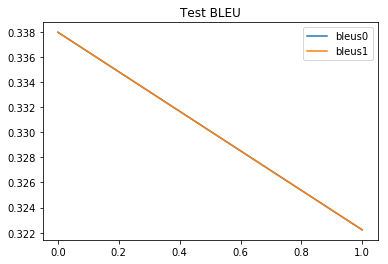

*** [Train]
*** Response
target: okay . everyone else ' s parents let
predic: i , i you ? s the me </s>


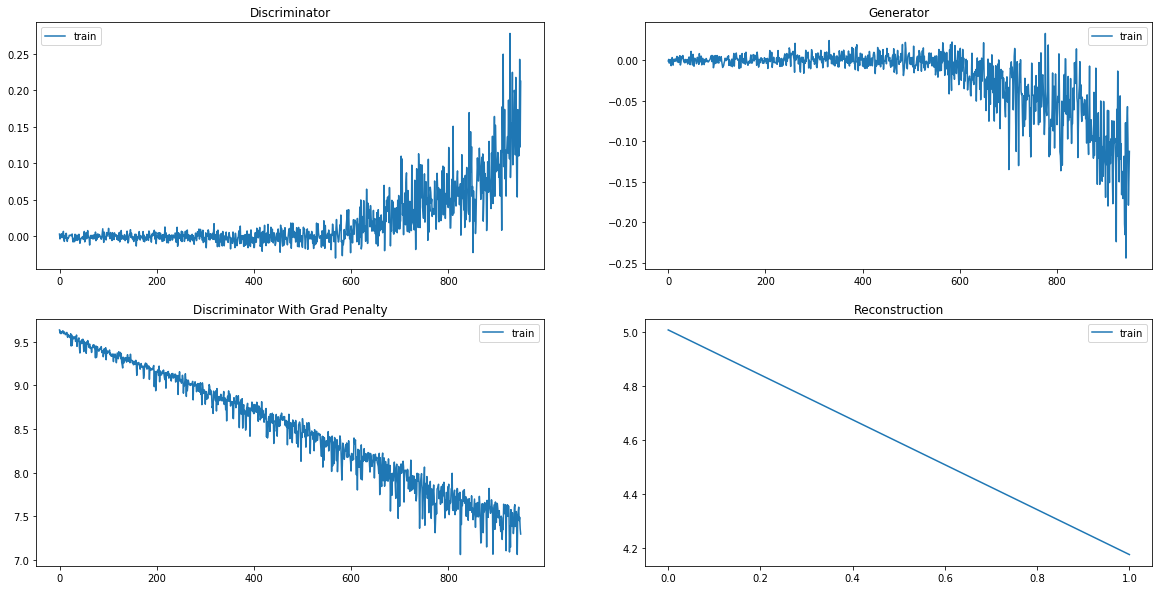

Train begins with 2374 batches with 14 left over samples

[Epcoh 3] ----------Mean Loss: 3.886220----------
Test begins with 6740 batches with 0 left over samples


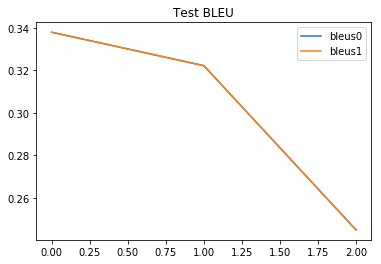

*** [Train]
*** Response
target: these vegetables taste very sweet . </s>
predic: hi are are of good . </s>


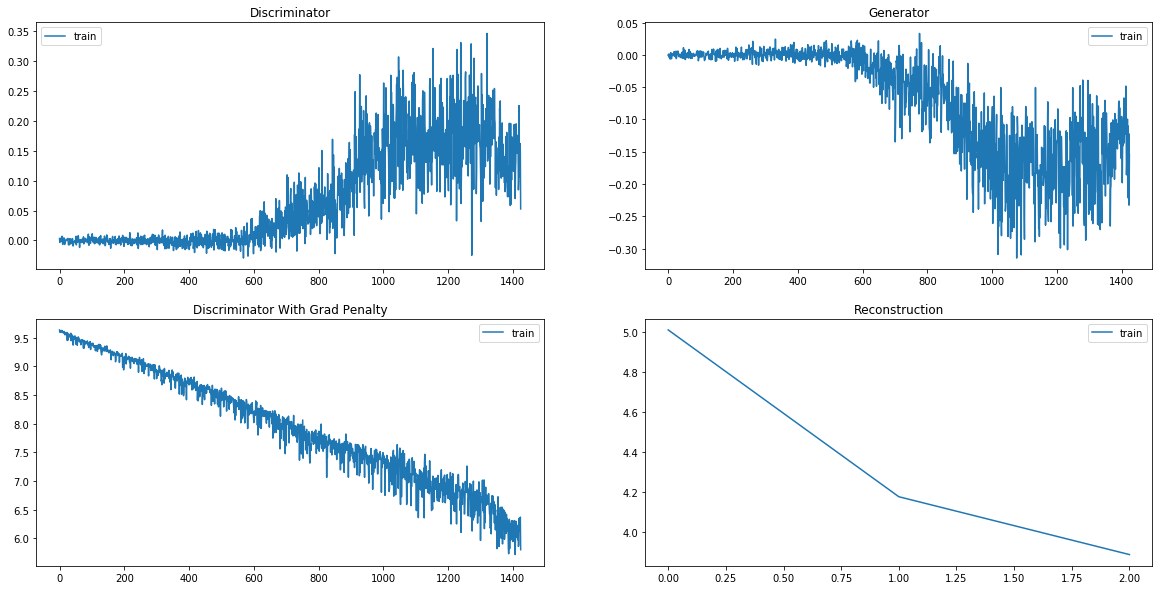

Train begins with 2374 batches with 14 left over samples

[Epcoh 4] ----------Mean Loss: 3.723999----------
Test begins with 6740 batches with 0 left over samples


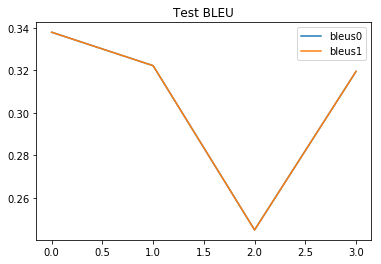

*** [Train]
*** Response
target: do you know how to set up the
predic: i you think what to say the ? </s>


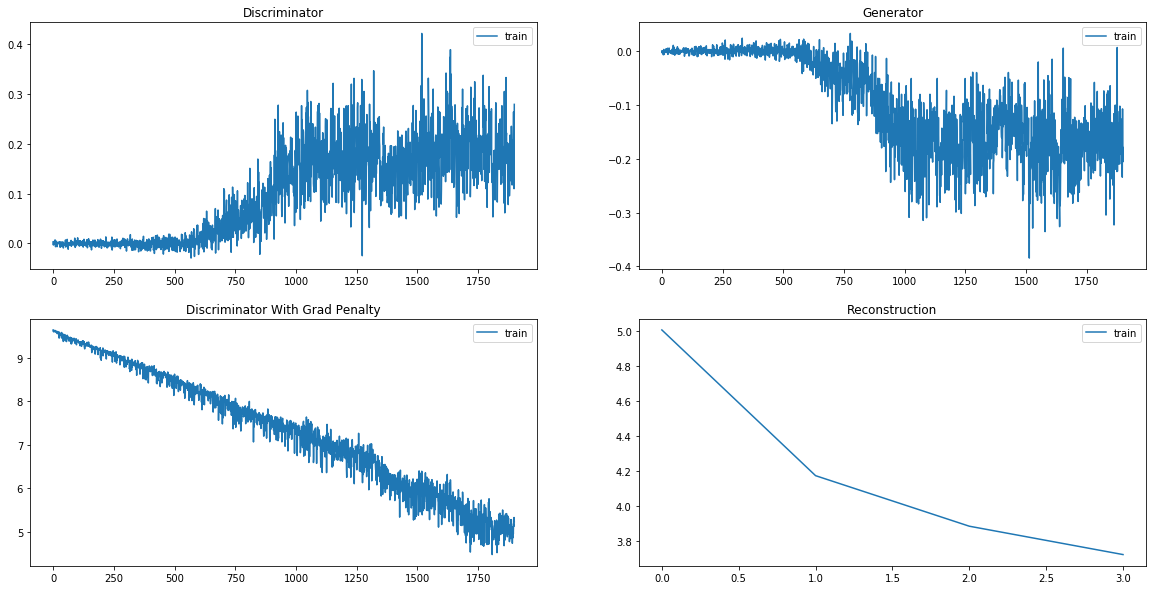

Train begins with 2374 batches with 14 left over samples

[Epcoh 5] ----------Mean Loss: 3.636980----------
Test begins with 6740 batches with 0 left over samples


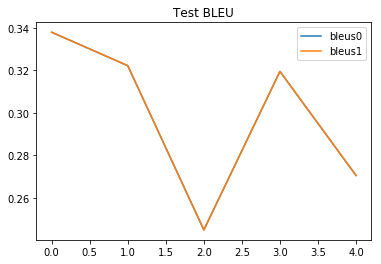

*** [Train]
*** Response
target: mary , there ' s one more thing
predic: hello , do ' s a . the </s>


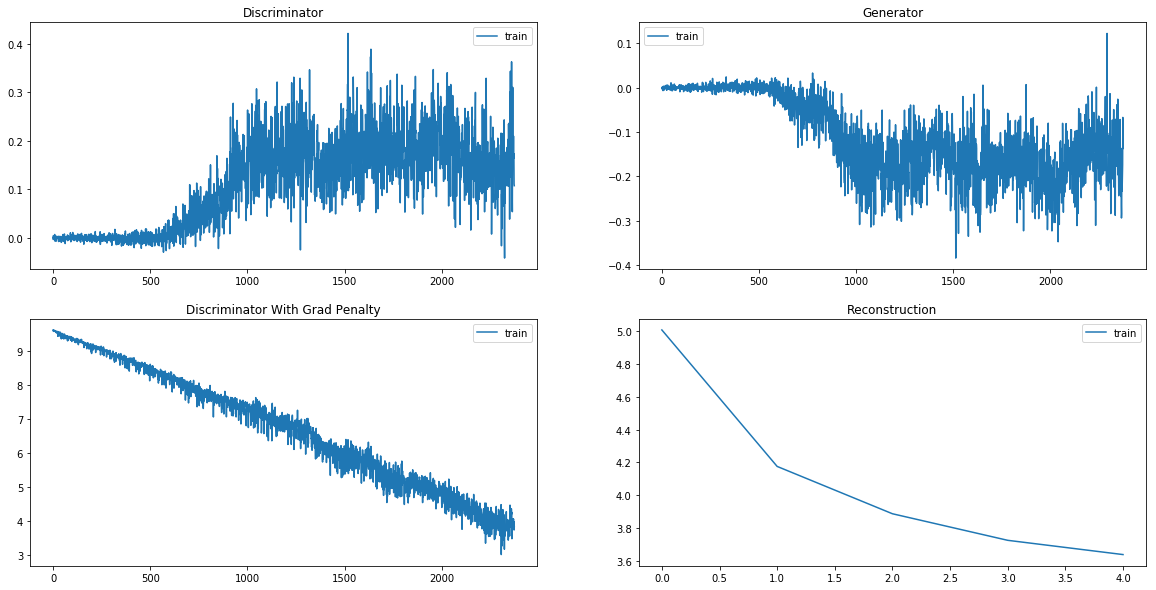

Train begins with 2374 batches with 14 left over samples

[Epcoh 6] ----------Mean Loss: 3.575641----------
Test begins with 6740 batches with 0 left over samples


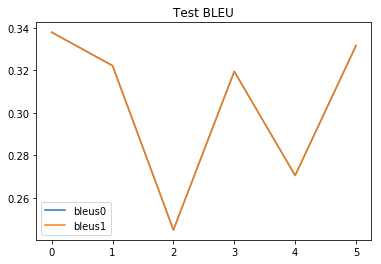

*** [Train]
*** Response
target: you ' re going to get into a
predic: i ' re so to the a the </s>


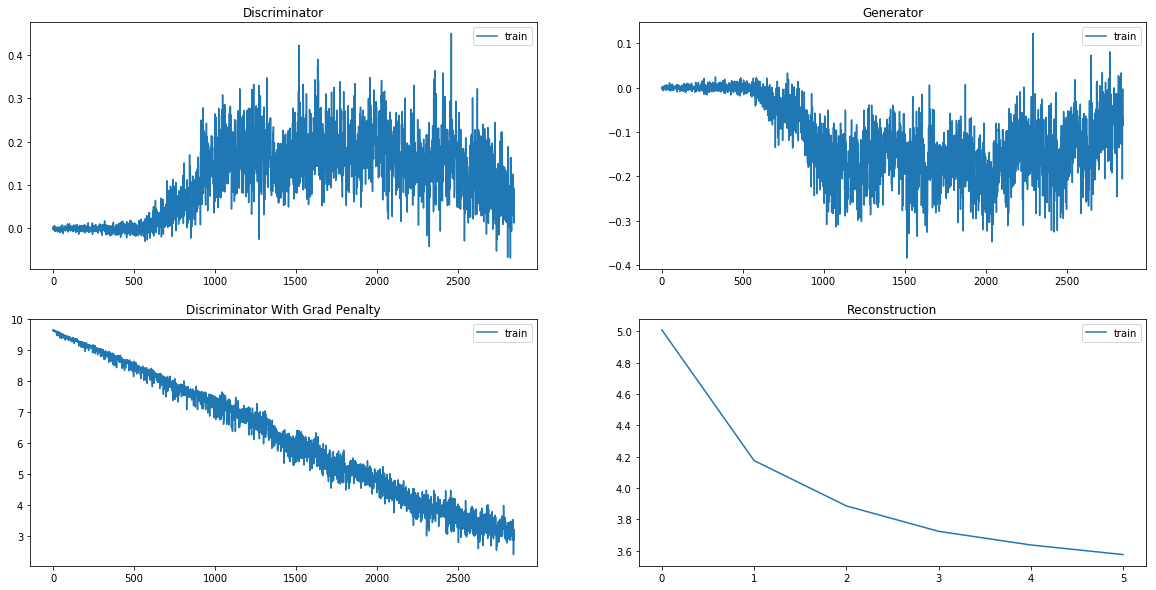

Train begins with 2374 batches with 14 left over samples

[Epcoh 7] ----------Mean Loss: 3.514020----------
Test begins with 6740 batches with 0 left over samples


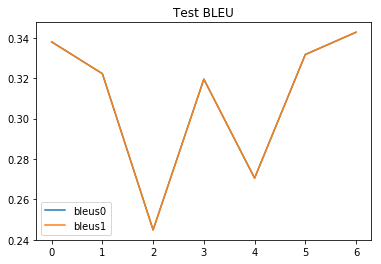

*** [Train]
*** Response
target: i love the beautiful lawn . what a
predic: yes ' it most . . </s>


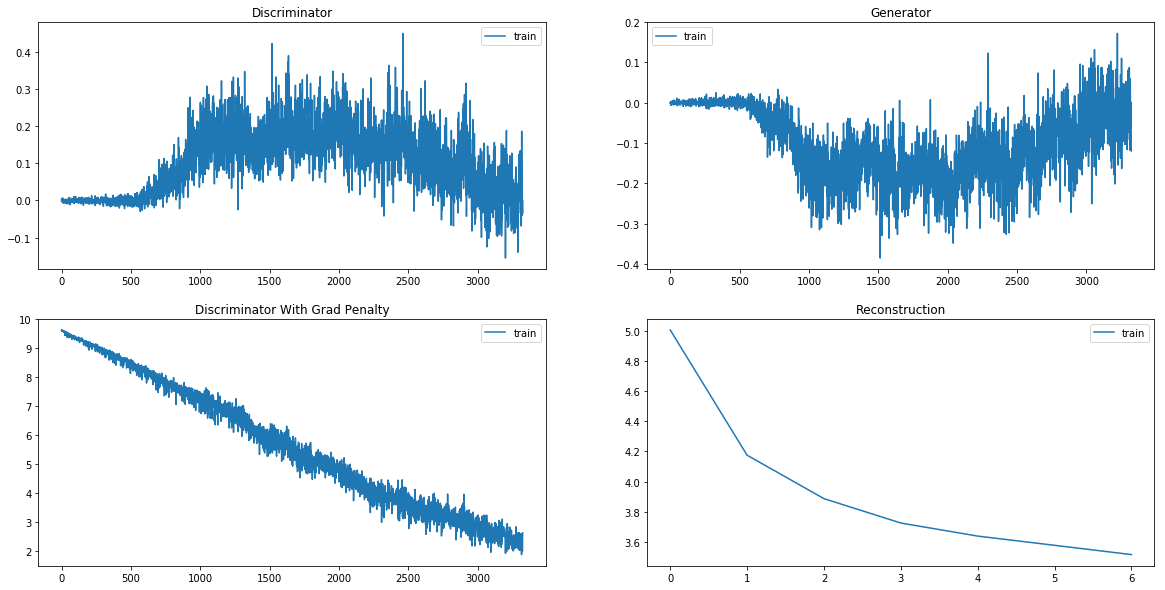

Train begins with 2374 batches with 14 left over samples

[Epcoh 8] ----------Mean Loss: 3.471591----------
Test begins with 6740 batches with 0 left over samples


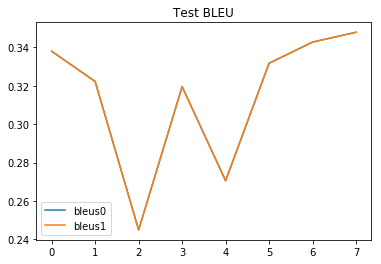

*** [Train]
*** Response
target: my opponent <unk> me with the very first
predic: you name is is too the <unk> important </s>


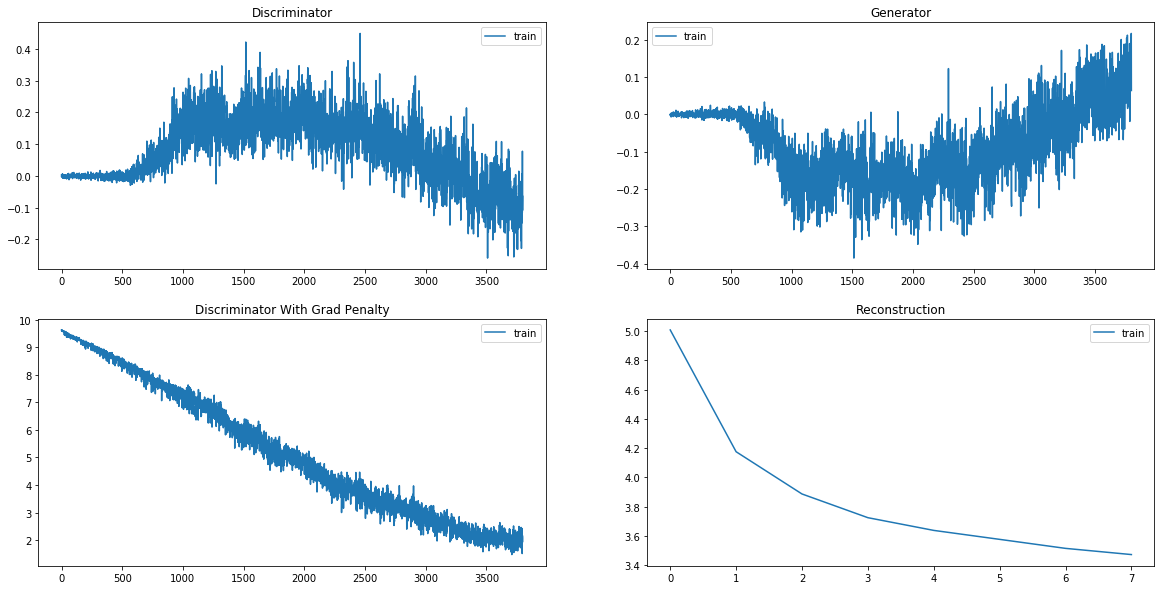

Train begins with 2374 batches with 14 left over samples

[Epcoh 9] ----------Mean Loss: 3.441847----------
Test begins with 6740 batches with 0 left over samples


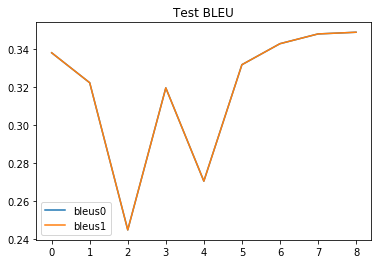

*** [Train]
*** Response
target: oh , it ’ s lovely . think
predic: yes , yes ’ s really . </s>


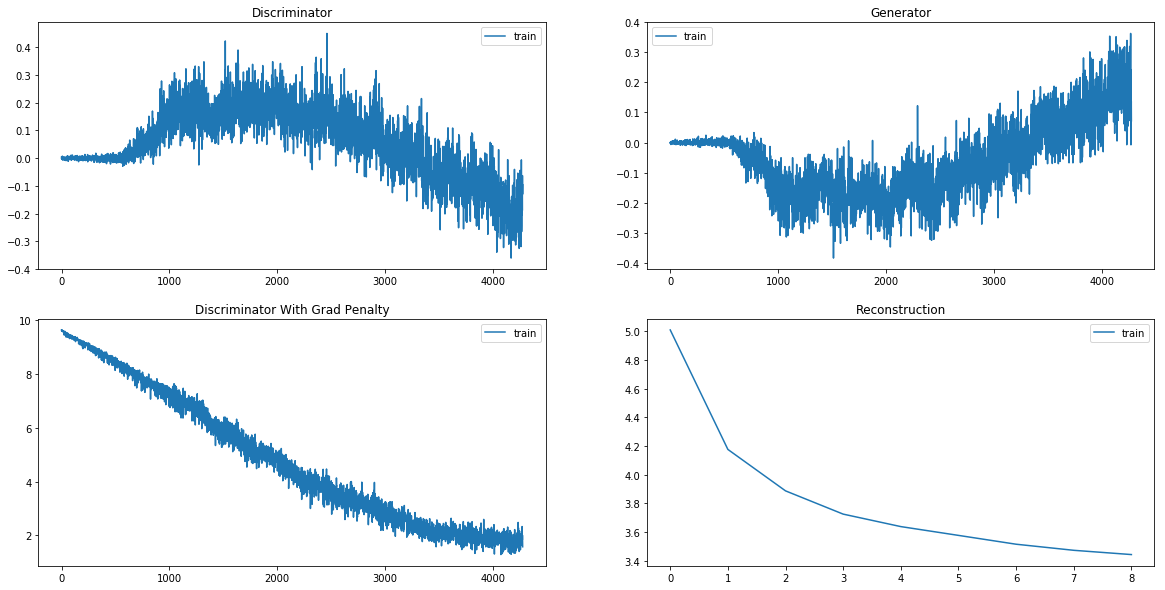

Train begins with 2374 batches with 14 left over samples

[Epcoh 10] ----------Mean Loss: 3.399314----------
Test begins with 6740 batches with 0 left over samples


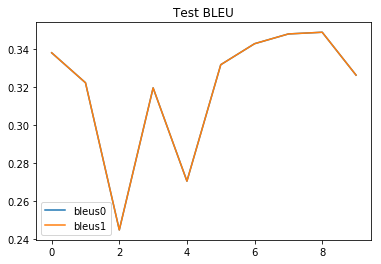

*** [Train]
*** Response
target: how time flies ! we have been lovers
predic: what about is are </s>


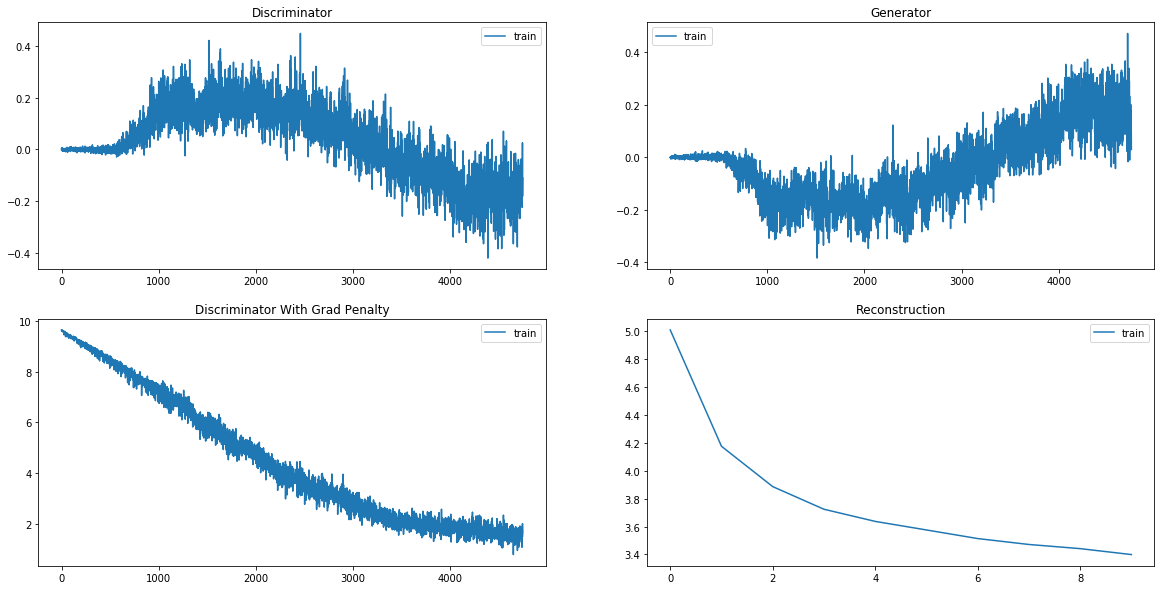

Train begins with 2374 batches with 14 left over samples

[Epcoh 11] ----------Mean Loss: 3.365485----------
Test begins with 6740 batches with 0 left over samples


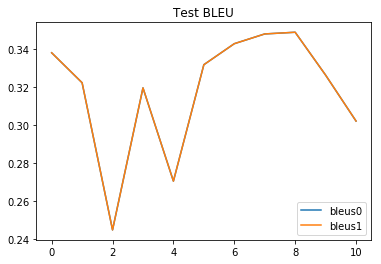

*** [Train]
*** Response
target: yes , it really needs redecorating . </s>
predic: i . i ' . to a </s>


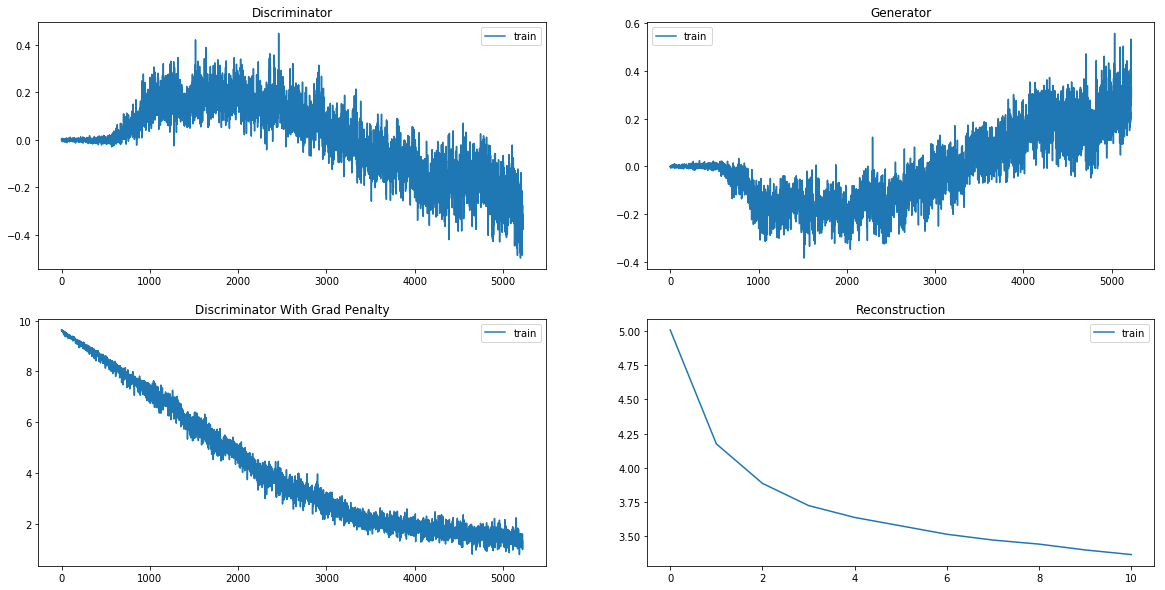

Train begins with 2374 batches with 14 left over samples

[Epcoh 12] ----------Mean Loss: 3.300486----------
Test begins with 6740 batches with 0 left over samples


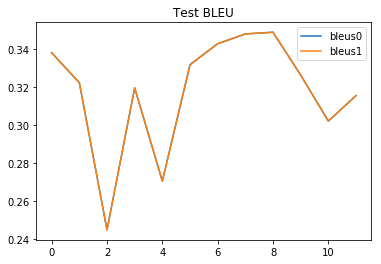

*** [Train]
*** Response
target: no , that ’ s may fifth in
predic: i , i ' s not . . </s>


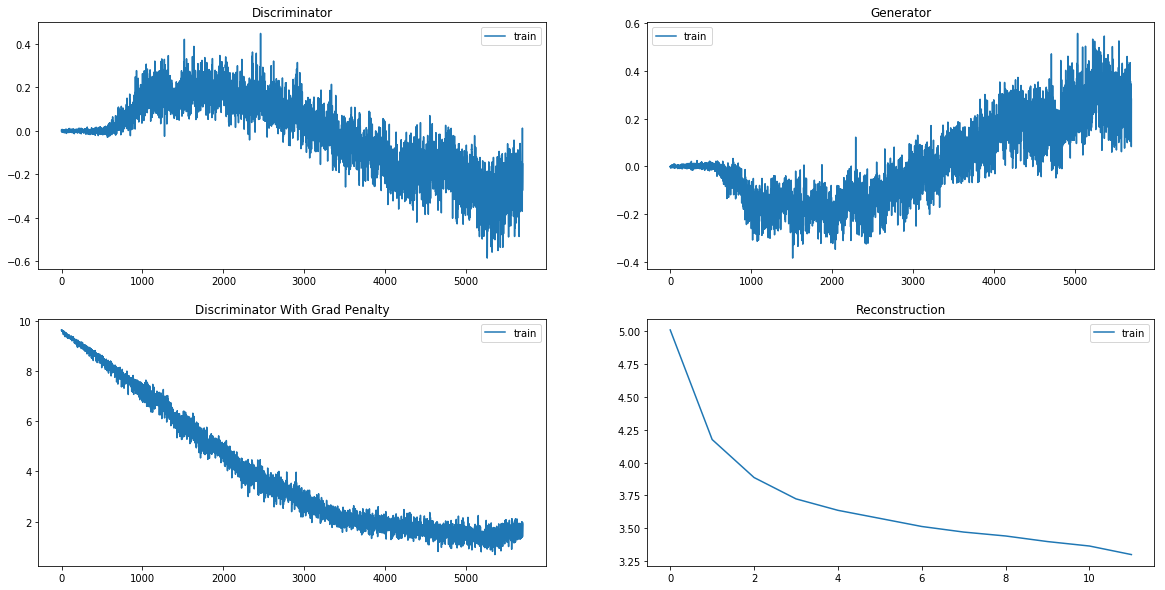

Train begins with 2374 batches with 14 left over samples

[Epcoh 13] ----------Mean Loss: 3.266634----------
Test begins with 6740 batches with 0 left over samples


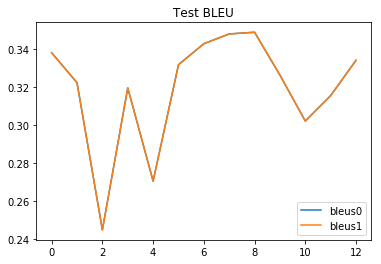

*** [Train]
*** Response
target: i had to look after my son at
predic: i ' a get at a own . </s>


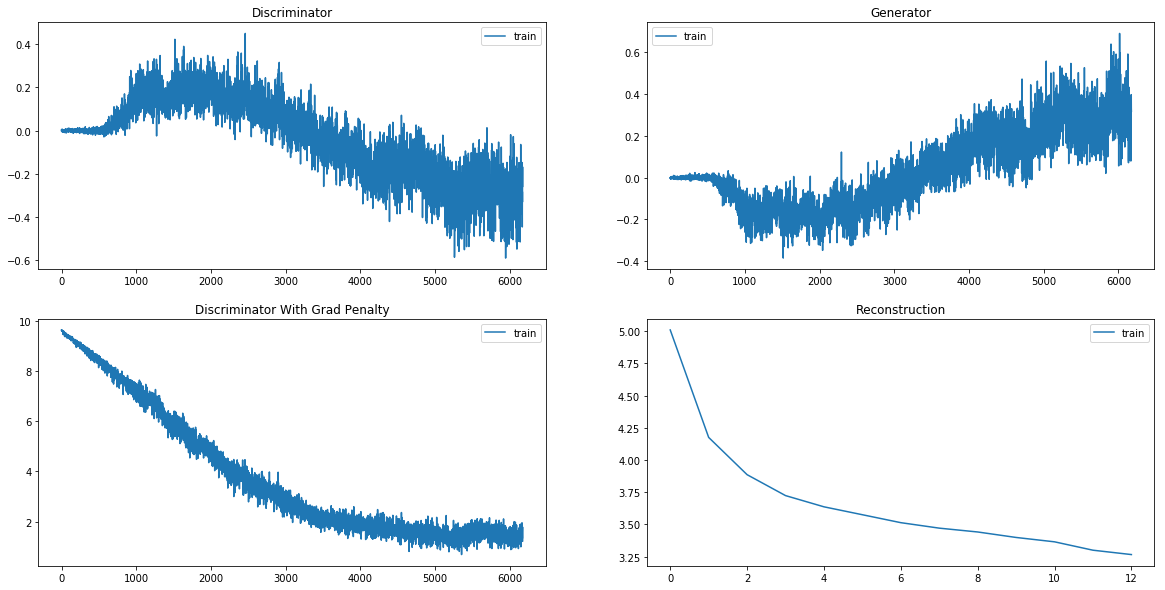

Train begins with 2374 batches with 14 left over samples

[Epcoh 14] ----------Mean Loss: 3.250048----------
Test begins with 6740 batches with 0 left over samples


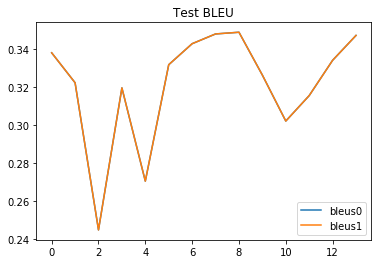

*** [Train]
*** Response
target: yes , but it ' s blurred and
predic: i , i i ' s a <unk> </s>


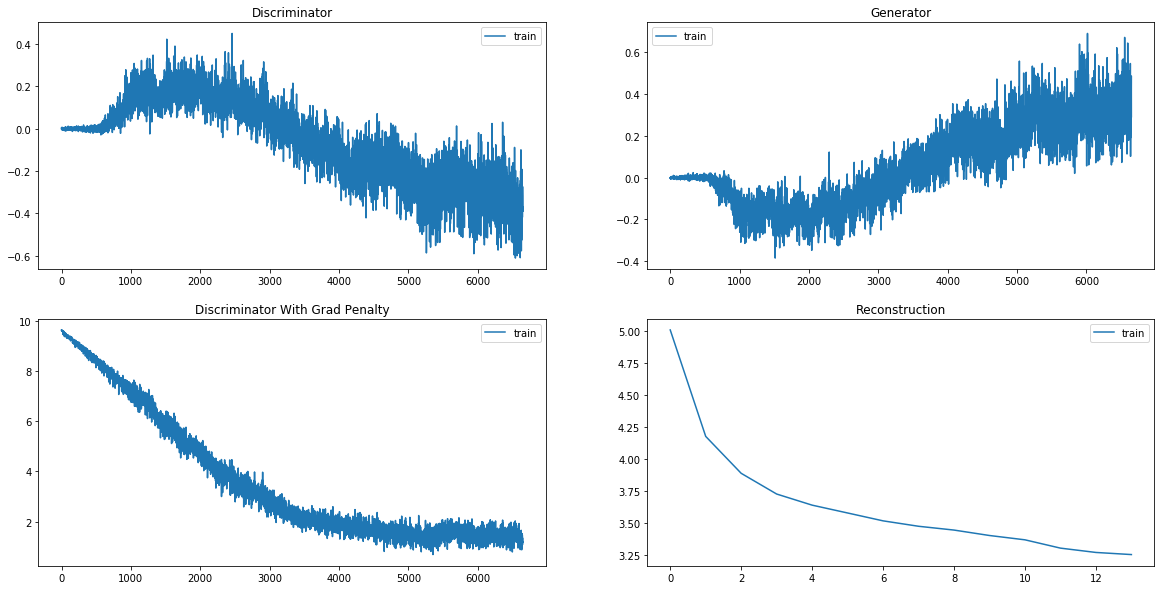

Train begins with 2374 batches with 14 left over samples

[Epcoh 15] ----------Mean Loss: 3.248862----------
Test begins with 6740 batches with 0 left over samples


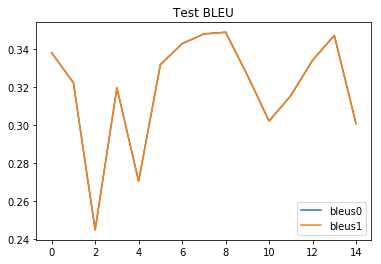

*** [Train]
*** Response
target: good ! how much is it ? </s>
predic: i . i much do it ? </s>


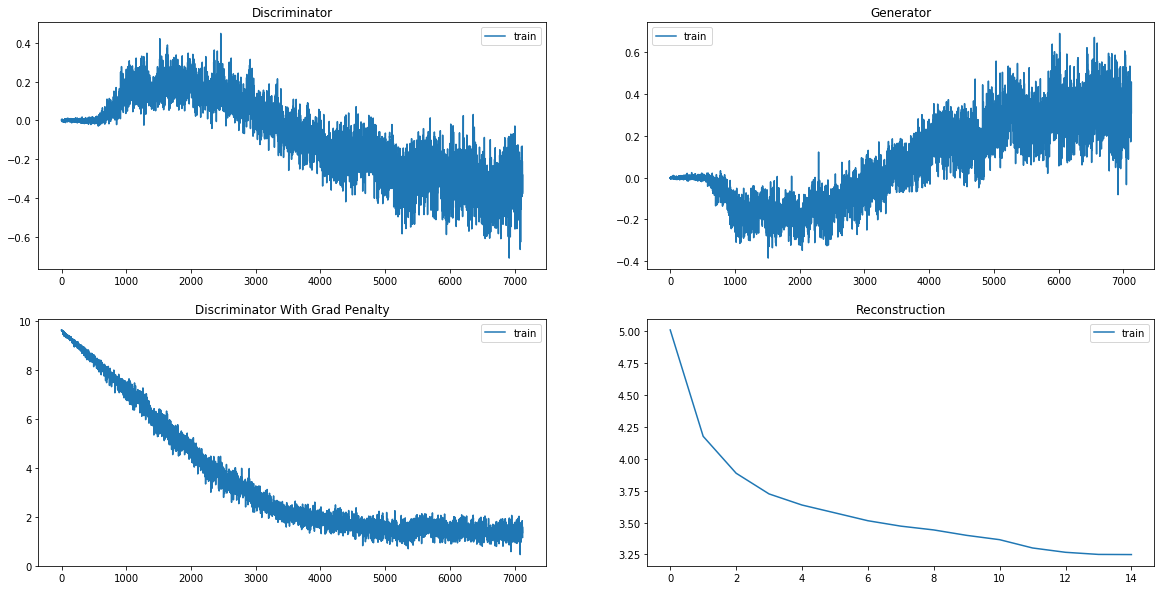

Train begins with 2374 batches with 14 left over samples

[Epcoh 16] ----------Mean Loss: 3.216283----------
Test begins with 6740 batches with 0 left over samples


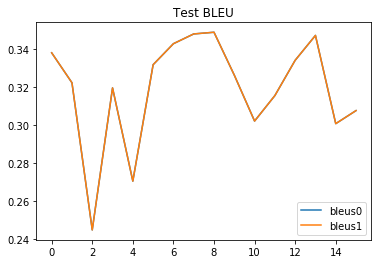

*** [Train]
*** Response
target: it will be sunday so i expected everything
predic: i ' be a . . have to </s>


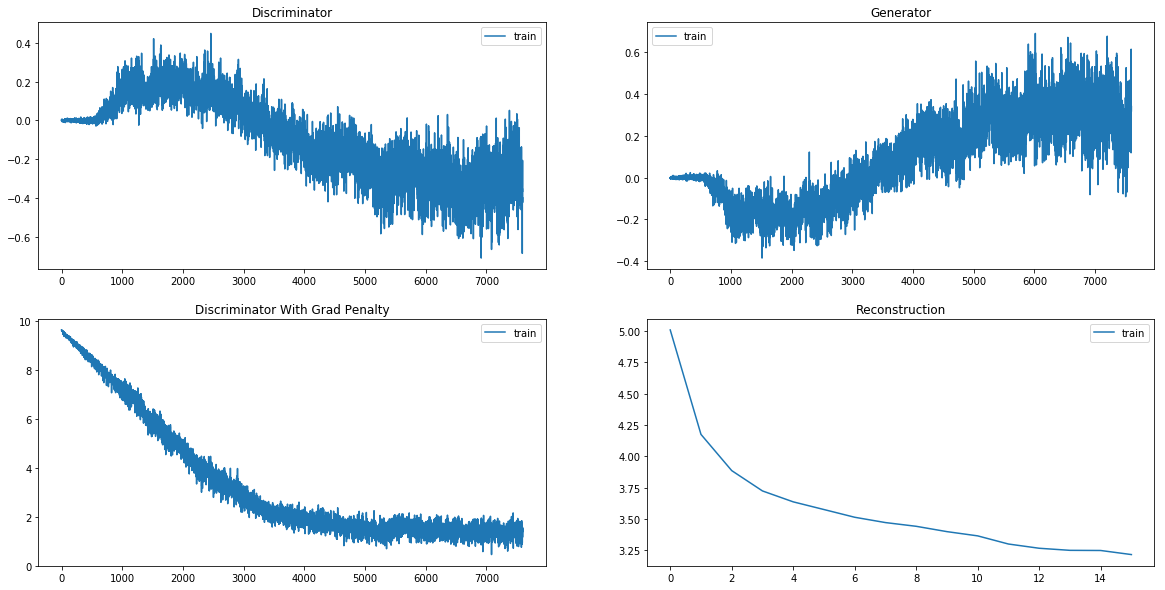

Train begins with 2374 batches with 14 left over samples

[Epcoh 17] ----------Mean Loss: 3.195498----------
Test begins with 6740 batches with 0 left over samples


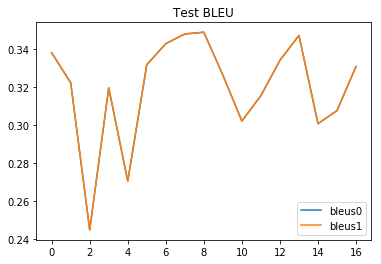

*** [Train]
*** Response
target: he ' s probably a <unk> . just
predic: yes ' s a to little . </s>


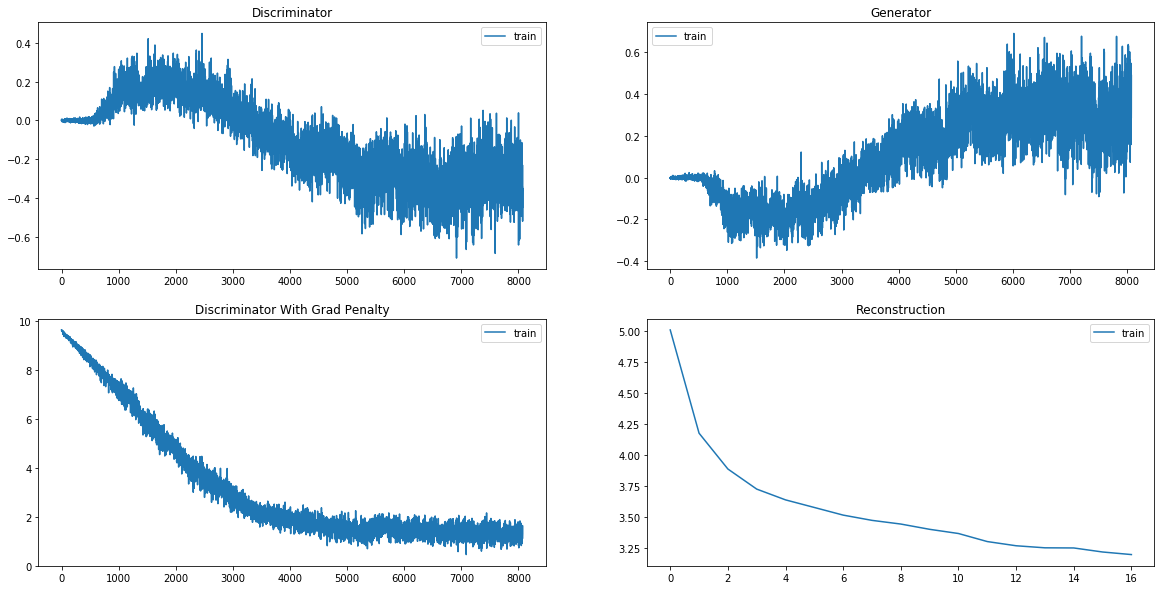

Train begins with 2374 batches with 14 left over samples

[Epcoh 18] ----------Mean Loss: 3.187141----------
Test begins with 6740 batches with 0 left over samples


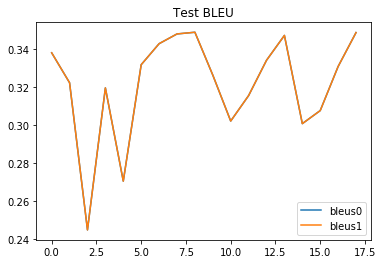

*** [Train]
*** Response
target: he is then in a very difficult situation
predic: i is a to the week good to </s>


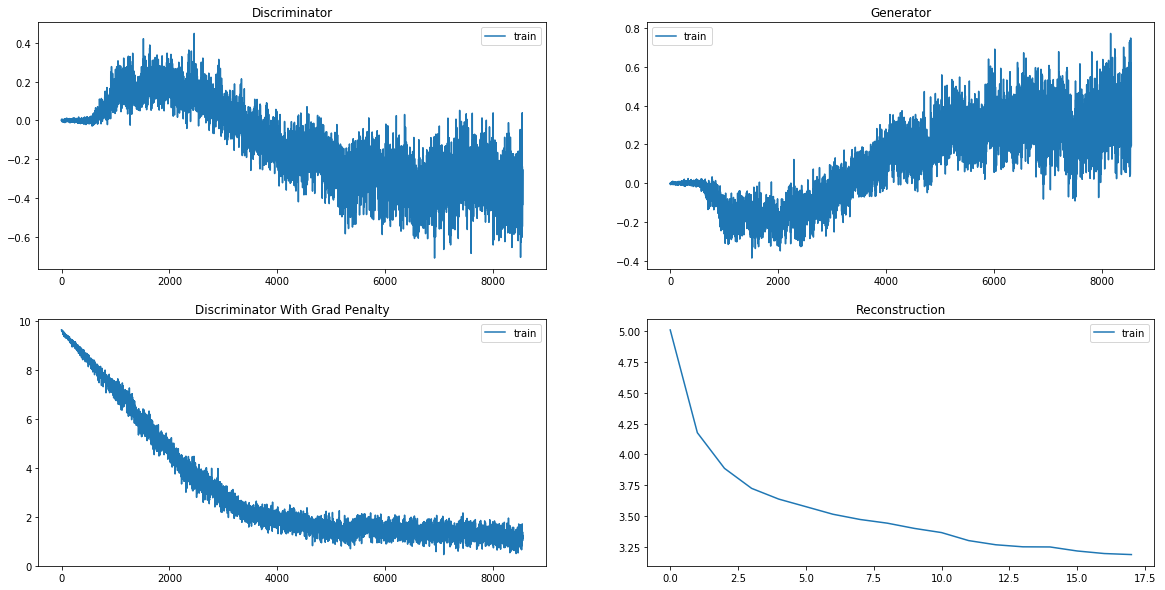

Train begins with 2374 batches with 14 left over samples

[Epcoh 19] ----------Mean Loss: 3.189317----------
Test begins with 6740 batches with 0 left over samples


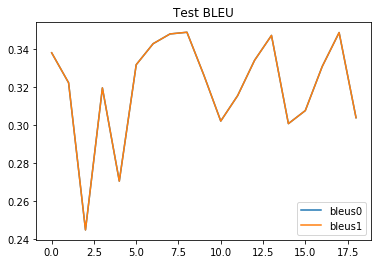

*** [Train]
*** Response
target: how do you get through the stuffy daytime
predic: i long you like your the job ? </s>


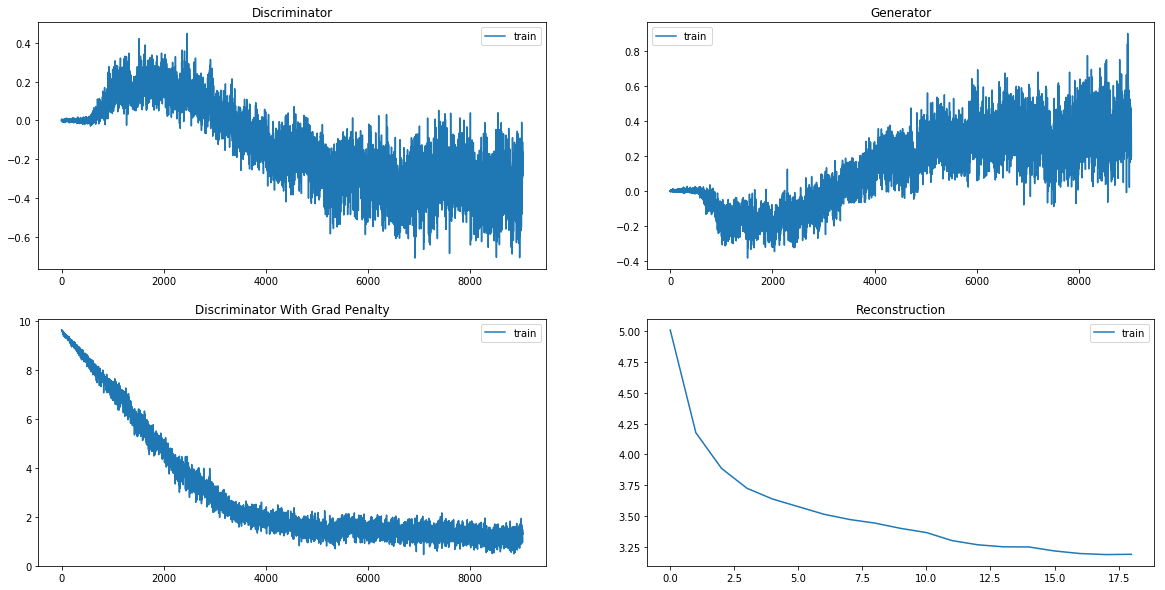

Train begins with 2374 batches with 14 left over samples

[Epcoh 20] ----------Mean Loss: 3.169667----------
Test begins with 6740 batches with 0 left over samples


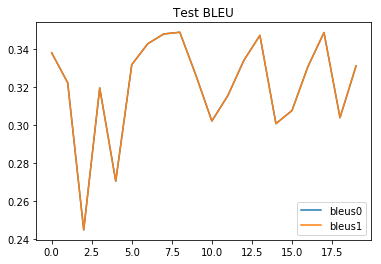

*** [Train]
*** Response
target: project management . i was very interested in
predic: i , . </s>


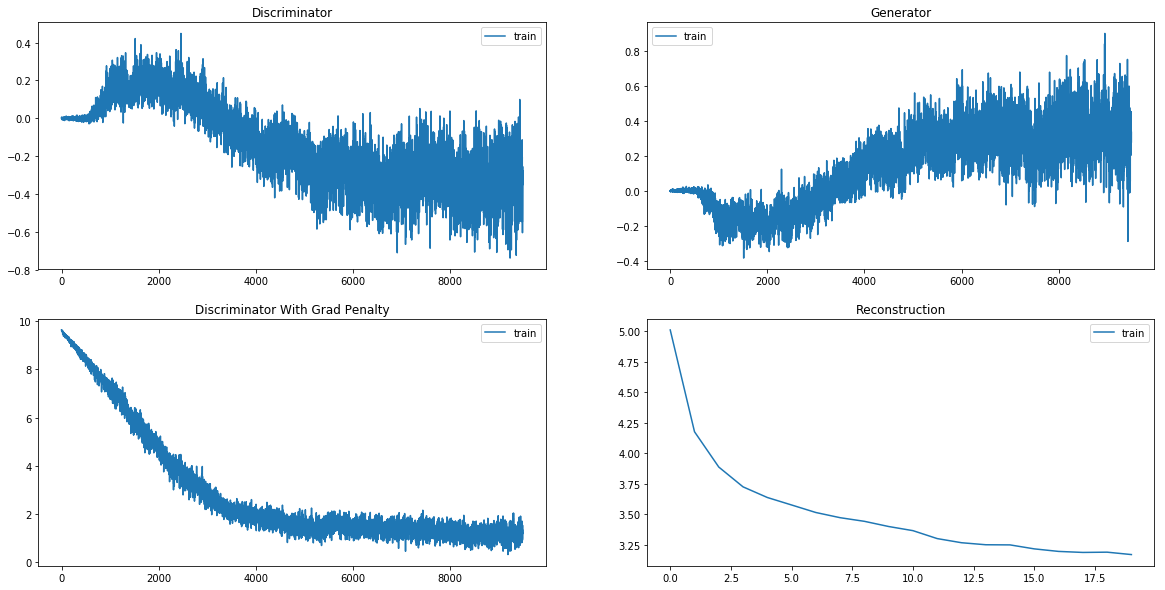

Train begins with 2374 batches with 14 left over samples

[Epcoh 21] ----------Mean Loss: 3.139051----------
Test begins with 6740 batches with 0 left over samples


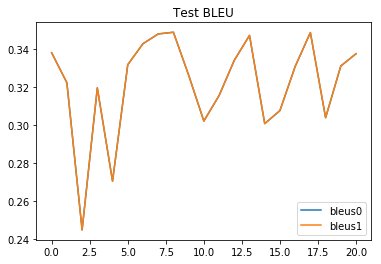

*** [Train]
*** Response
target: yes . how much do you charge for
predic: i , i many is you want ? </s>


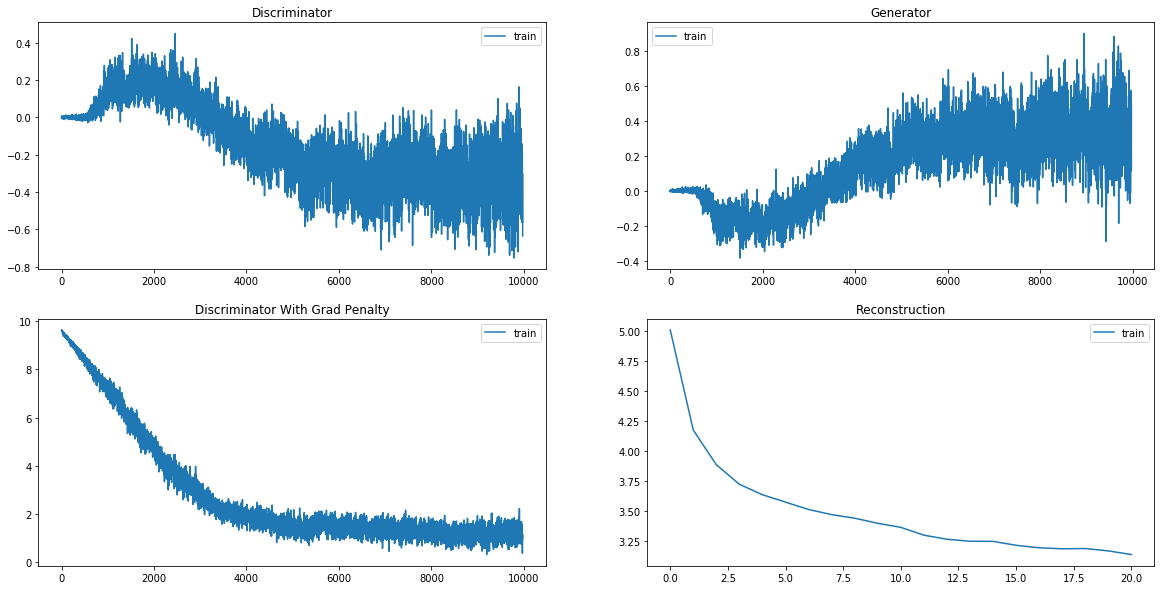

Train begins with 2374 batches with 14 left over samples

[Epcoh 22] ----------Mean Loss: 3.110864----------
Test begins with 6740 batches with 0 left over samples


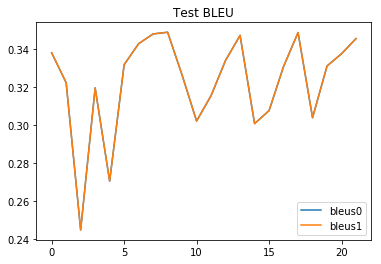

*** [Train]
*** Response
target: oh , certainly . i wouldn ' t
predic: i , that . i ' ' t </s>


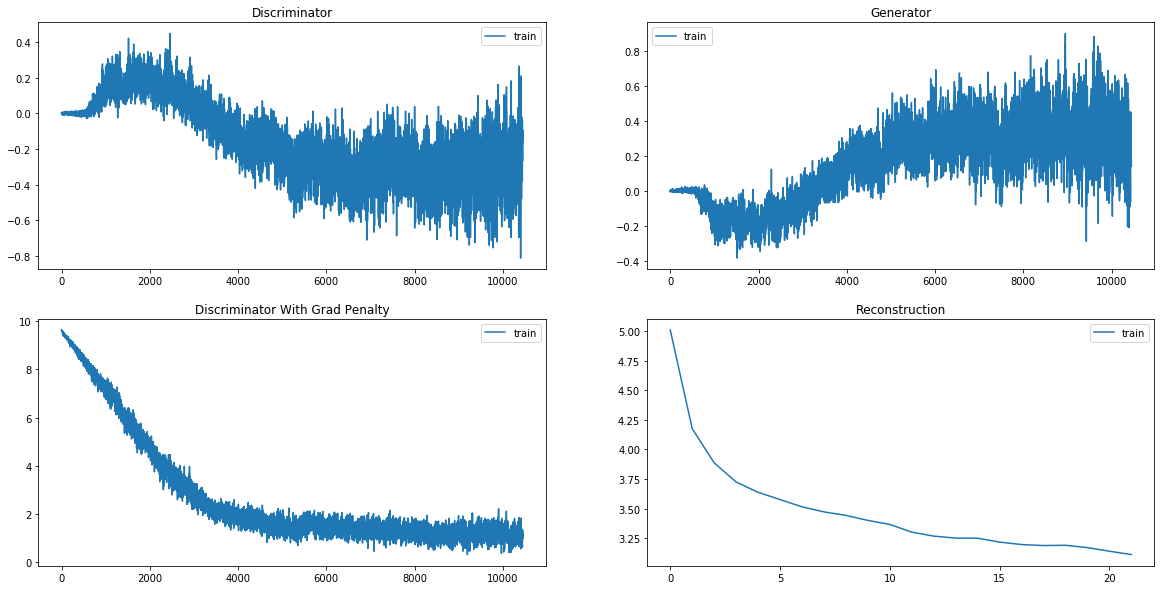

Train begins with 2374 batches with 14 left over samples

[Epcoh 23] ----------Mean Loss: 3.084082----------
Test begins with 6740 batches with 0 left over samples


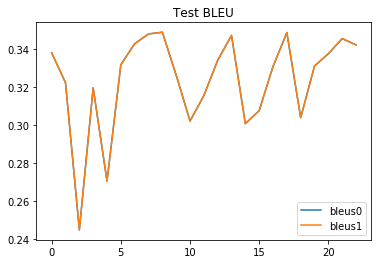

*** [Train]
*** Response
target: five tens , five <unk> and the rest
predic: i dollars , please yuan . <unk> water </s>


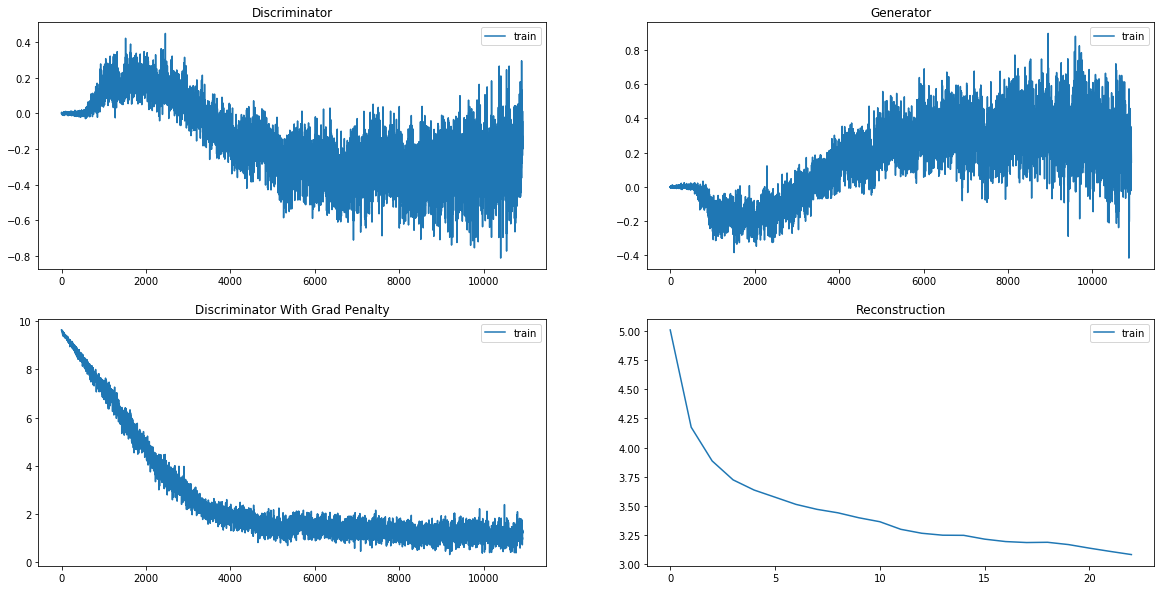

Train begins with 2374 batches with 14 left over samples

[Epcoh 24] ----------Mean Loss: 3.063602----------
Test begins with 6740 batches with 0 left over samples


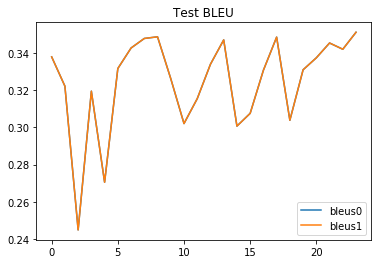

*** [Train]
*** Response
target: perhaps you are right . but i still
predic: i you have . . i we don </s>


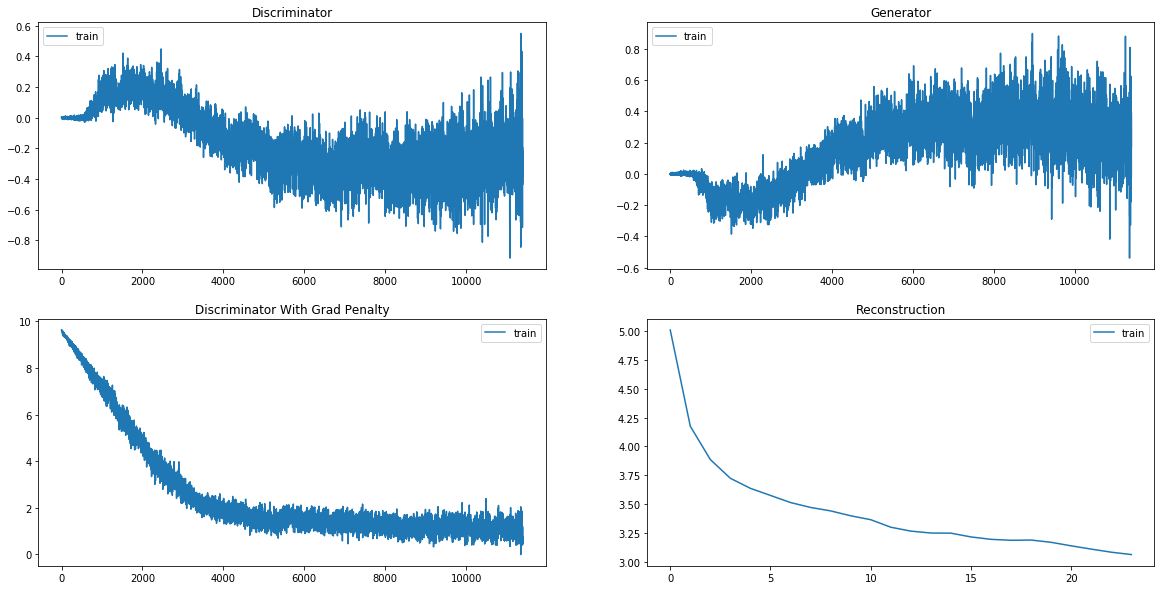

Train begins with 2374 batches with 14 left over samples

[Epcoh 25] ----------Mean Loss: 3.074493----------
Test begins with 6740 batches with 0 left over samples


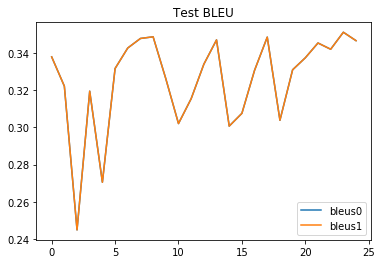

*** [Train]
*** Response
target: no , i will stay another day .
predic: i , i don . there . . </s>


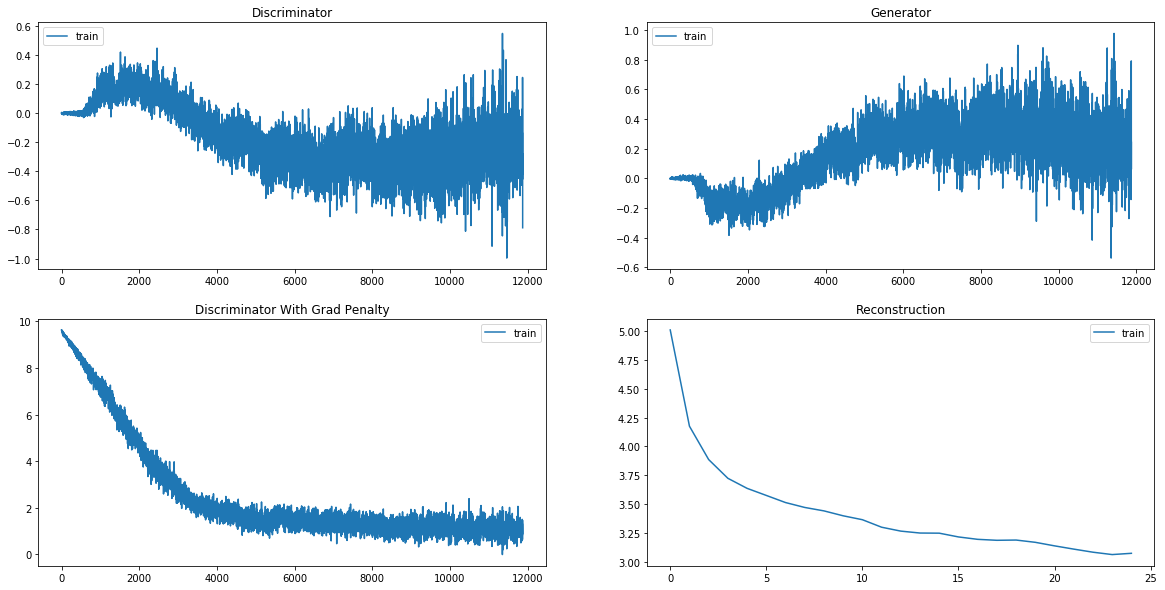

Train begins with 2374 batches with 14 left over samples

[Epcoh 26] ----------Mean Loss: 3.054982----------
Test begins with 6740 batches with 0 left over samples


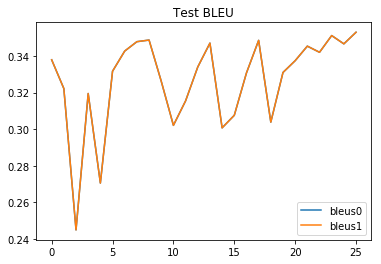

*** [Train]
*** Response
target: it ' s a pity . say ,
predic: i ' s a good . i , </s>


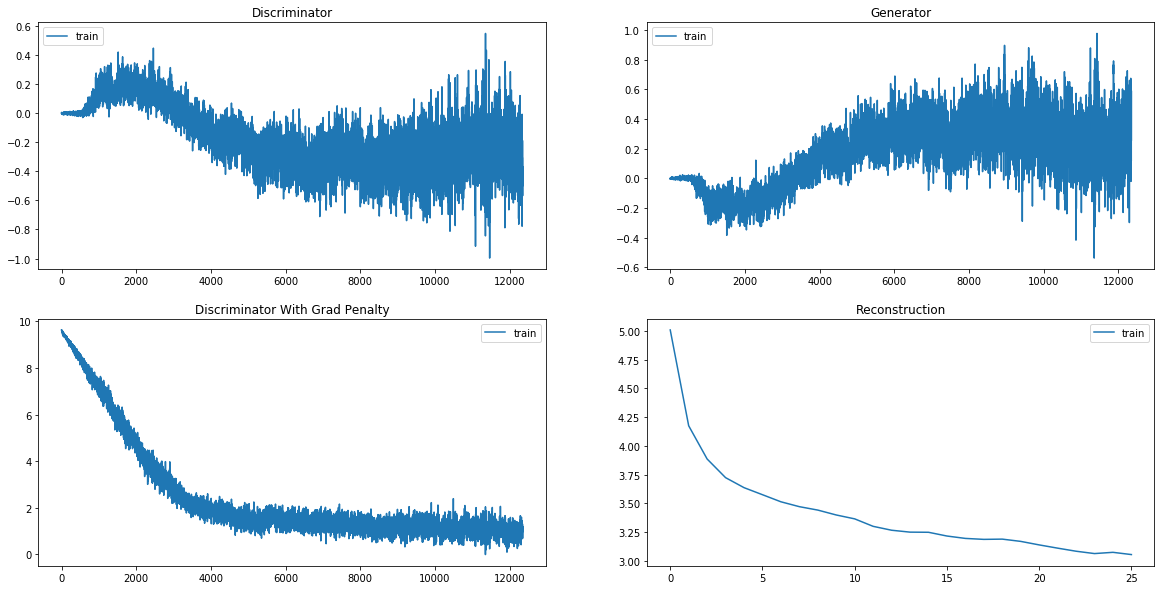

Train begins with 2374 batches with 14 left over samples

[Epcoh 27] ----------Mean Loss: 3.059363----------
Test begins with 6740 batches with 0 left over samples


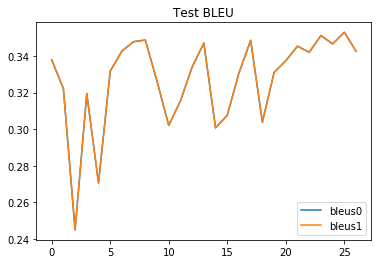

*** [Train]
*** Response
target: the <unk> will give us a 10 %
predic: i price is be you your few of </s>


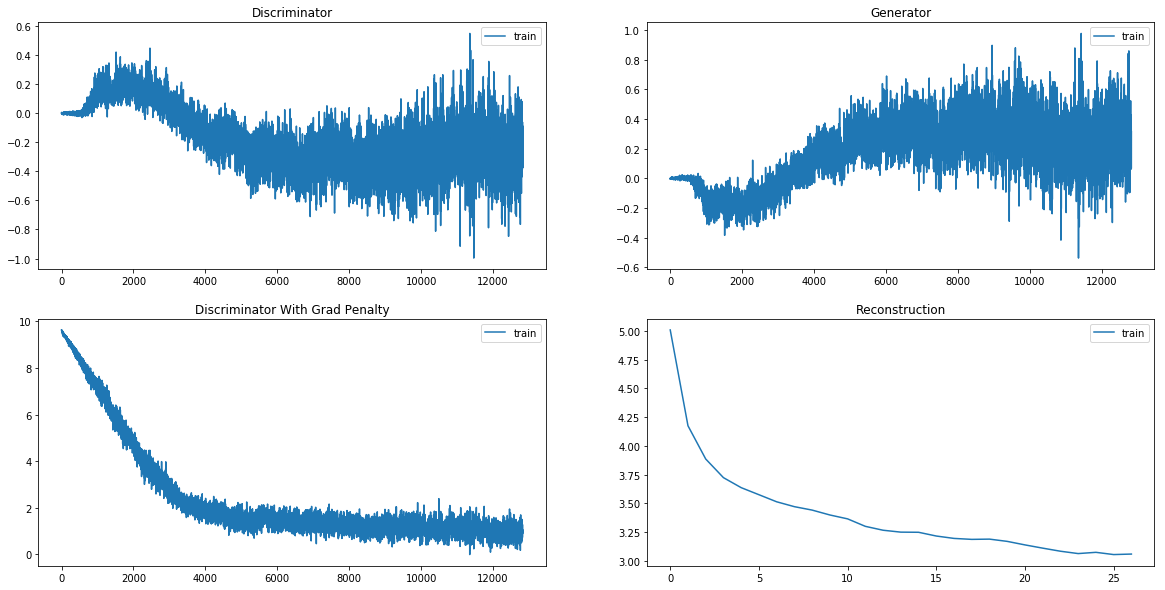

Train begins with 2374 batches with 14 left over samples

[Epcoh 28] ----------Mean Loss: 3.043407----------
Test begins with 6740 batches with 0 left over samples


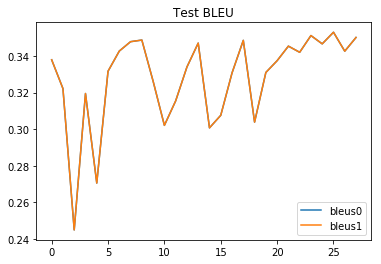

*** [Train]
*** Response
target: well , i ' ve lost my wallet
predic: i , i ' m got some wallet </s>


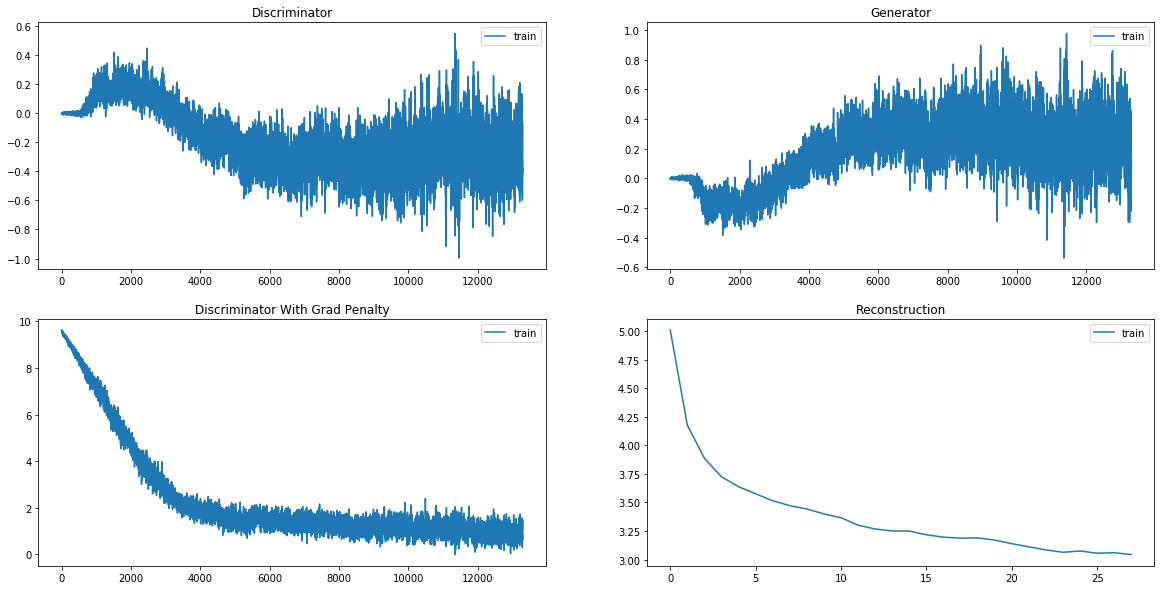

Train begins with 2374 batches with 14 left over samples

[Epcoh 29] ----------Mean Loss: 3.039361----------
Test begins with 6740 batches with 0 left over samples


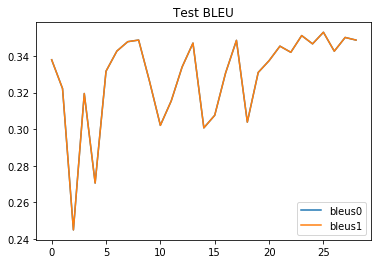

*** [Train]
*** Response
target: no problem . </s>
predic: i , . </s>


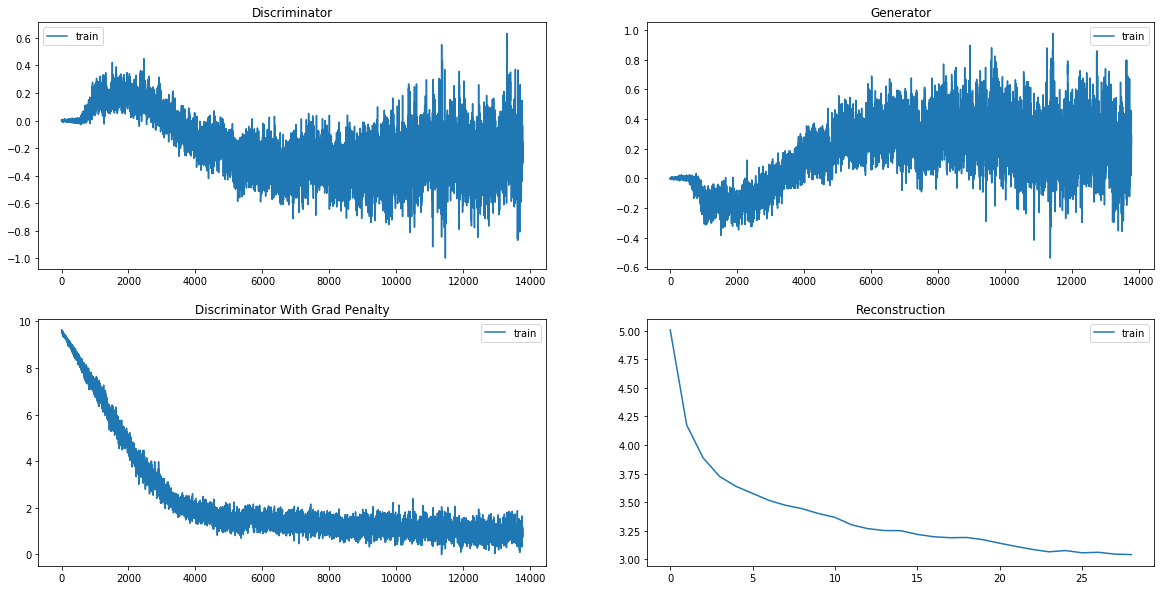

Train begins with 2374 batches with 14 left over samples

[Epcoh 30] ----------Mean Loss: 3.046428----------
Test begins with 6740 batches with 0 left over samples


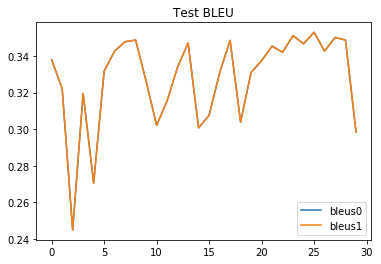

*** [Train]
*** Response
target: no , i shouldn ' t think so
predic: i , i don ' t . so </s>


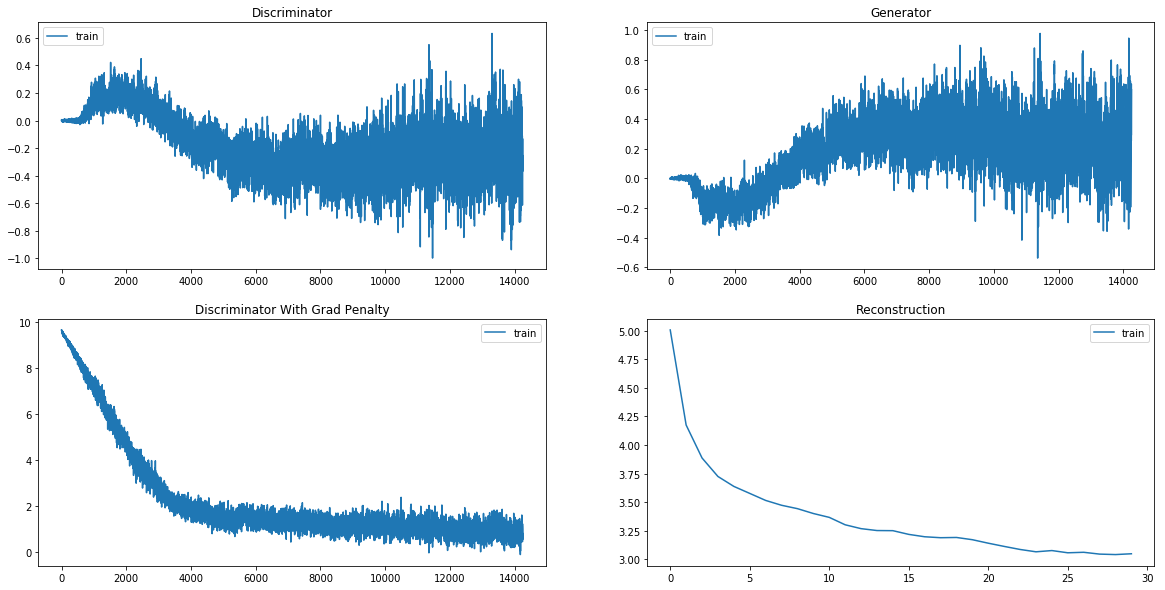

Train begins with 2374 batches with 14 left over samples

[Epcoh 31] ----------Mean Loss: 3.006383----------
Test begins with 6740 batches with 0 left over samples


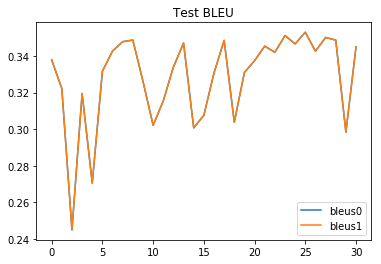

*** [Train]
*** Response
target: what kinds do you have ? </s>
predic: i ' of you like in </s>


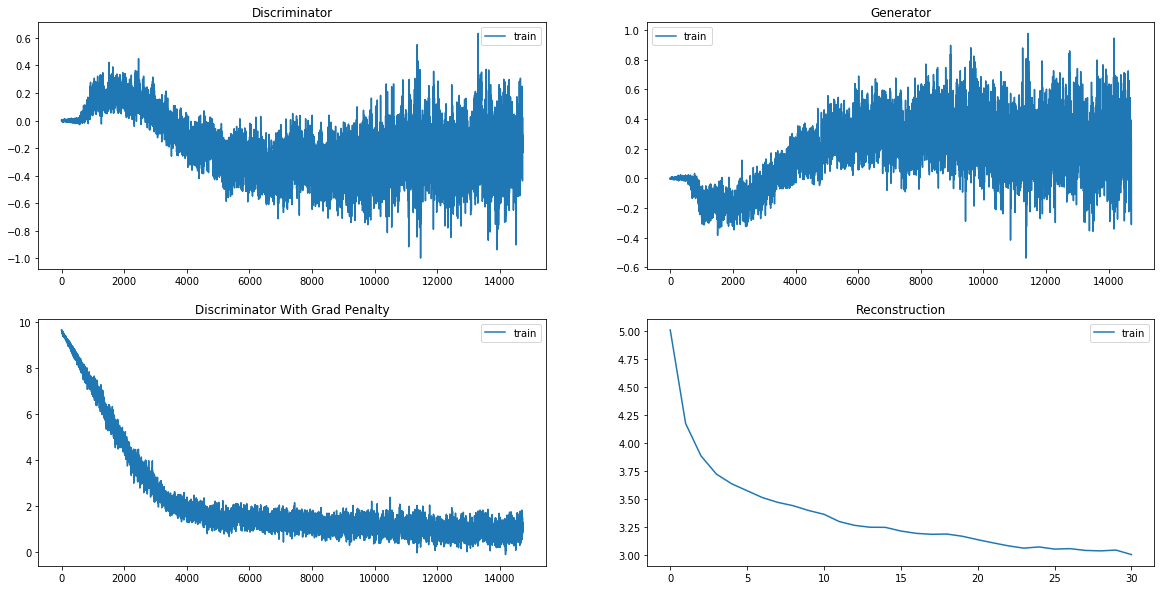

Train begins with 2374 batches with 14 left over samples

[Epcoh 32] ----------Mean Loss: 3.007569----------
Test begins with 6740 batches with 0 left over samples


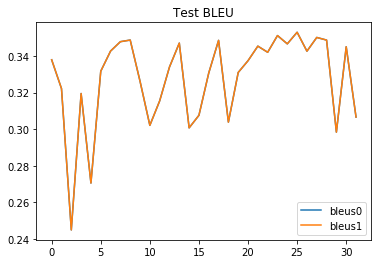

*** [Train]
*** Response
target: what ’ s wrong with it ? </s>
predic: i do s the with it ? </s>


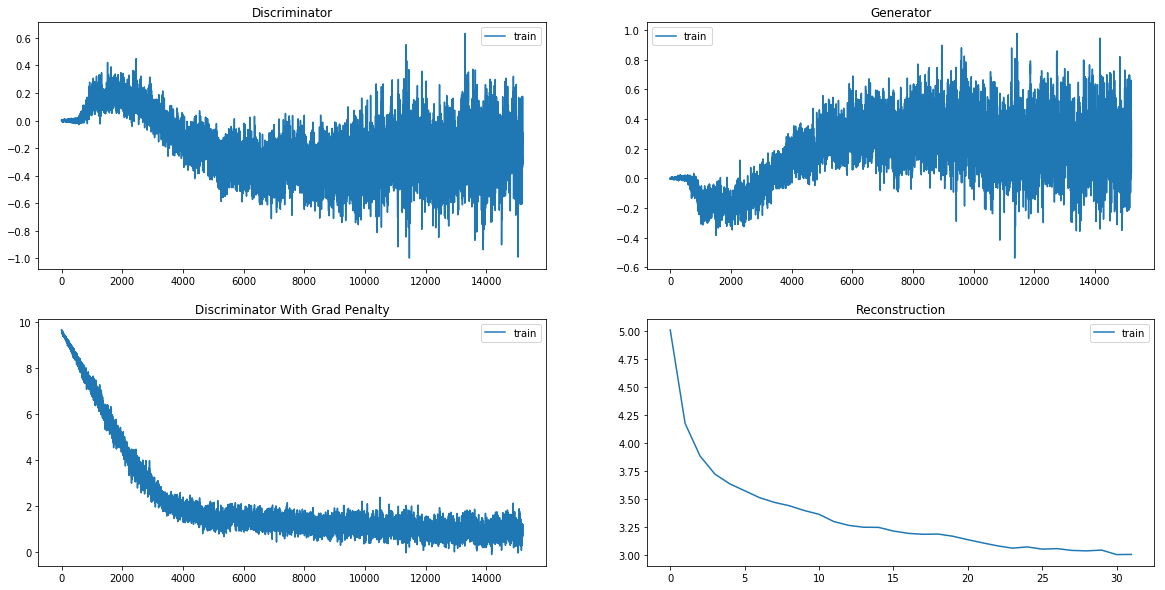

Train begins with 2374 batches with 14 left over samples

[Epcoh 33] ----------Mean Loss: 2.988670----------
Test begins with 6740 batches with 0 left over samples


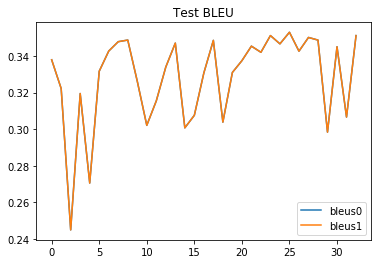

*** [Train]
*** Response
target: that would be a definite bonus . </s>
predic: i ' be great great . . </s>


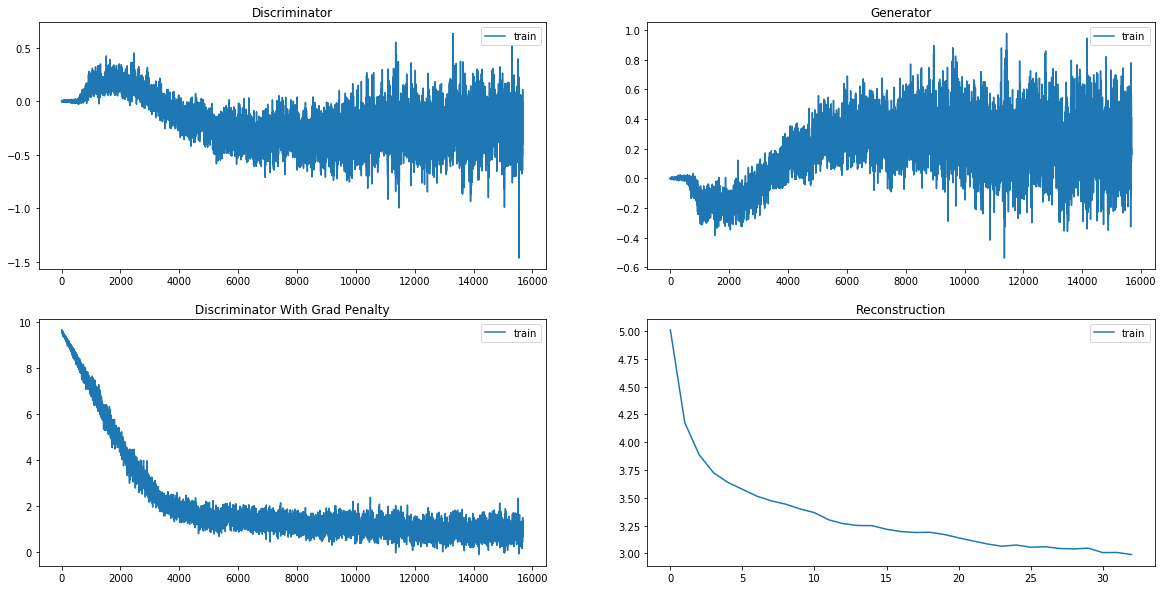

Train begins with 2374 batches with 14 left over samples

[Epcoh 34] ----------Mean Loss: 2.991934----------
Test begins with 6740 batches with 0 left over samples


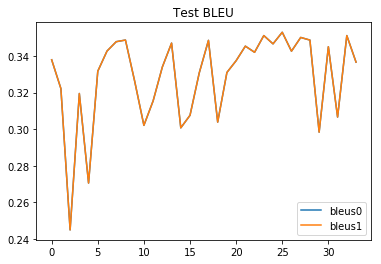

*** [Train]
*** Response
target: what happened ? </s>
predic: i kind ? </s>


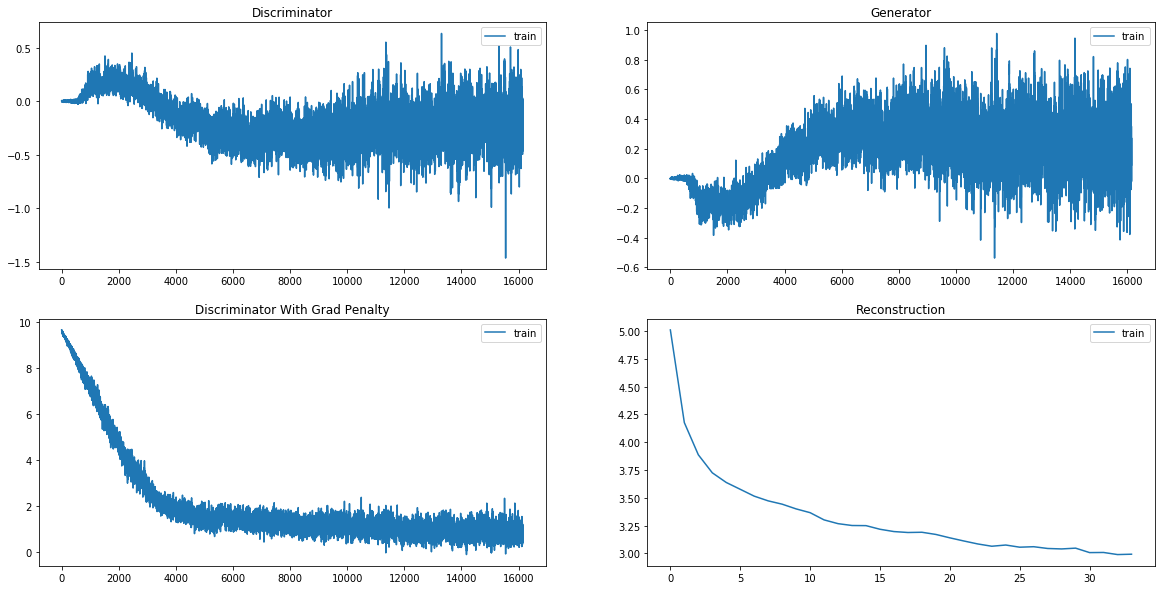

Train begins with 2374 batches with 14 left over samples

[Epcoh 35] ----------Mean Loss: 2.972300----------
Test begins with 6740 batches with 0 left over samples


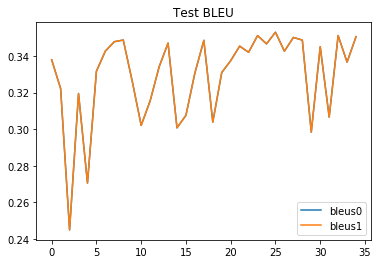

*** [Train]
*** Response
target: where will we call at ? </s>
predic: i did you be ? the </s>


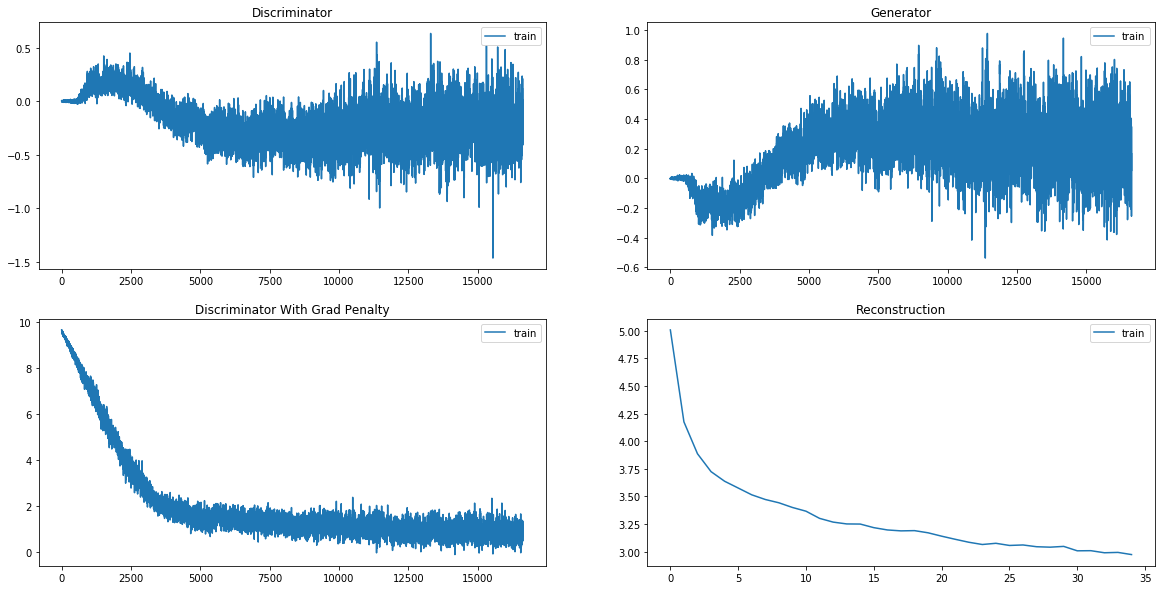

Train begins with 2374 batches with 14 left over samples

[Epcoh 36] ----------Mean Loss: 2.971627----------
Test begins with 6740 batches with 0 left over samples


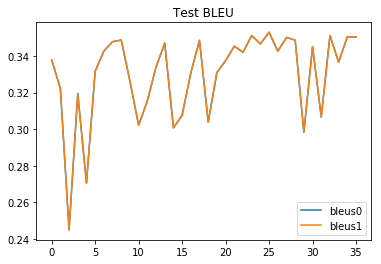

*** [Train]
*** Response
target: but that is terrible ! i am only
predic: i i ' the . </s>


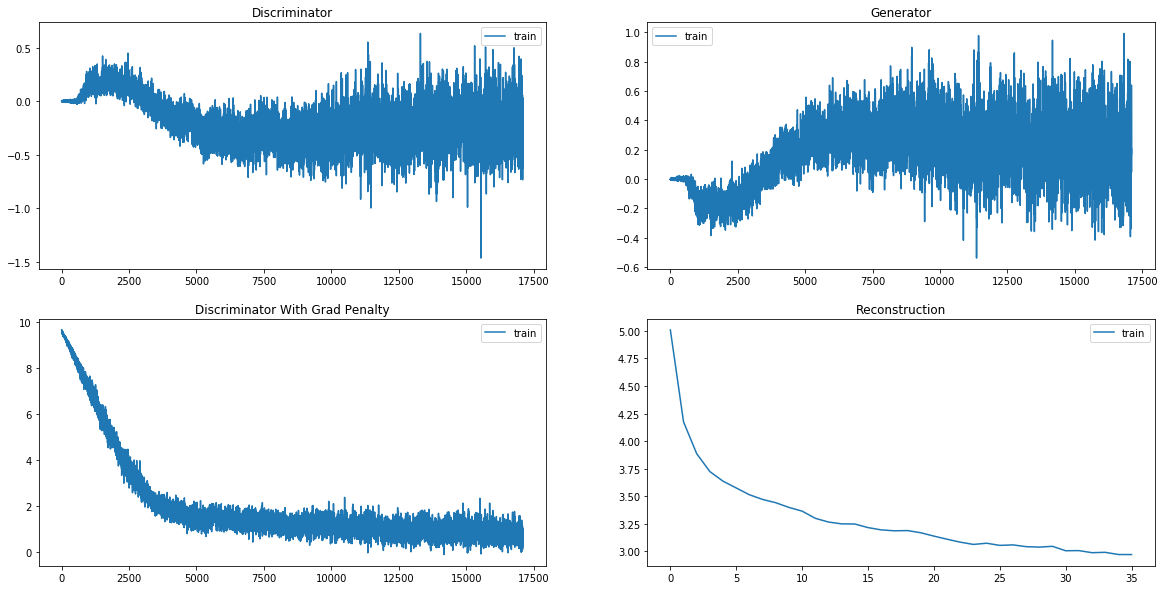

Train begins with 2374 batches with 14 left over samples

[Epcoh 37] ----------Mean Loss: 2.981055----------
Test begins with 6740 batches with 0 left over samples


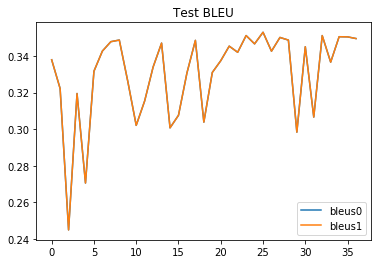

*** [Train]
*** Response
target: you already finished off everything , sir ?
predic: i ' have the the . but ? </s>


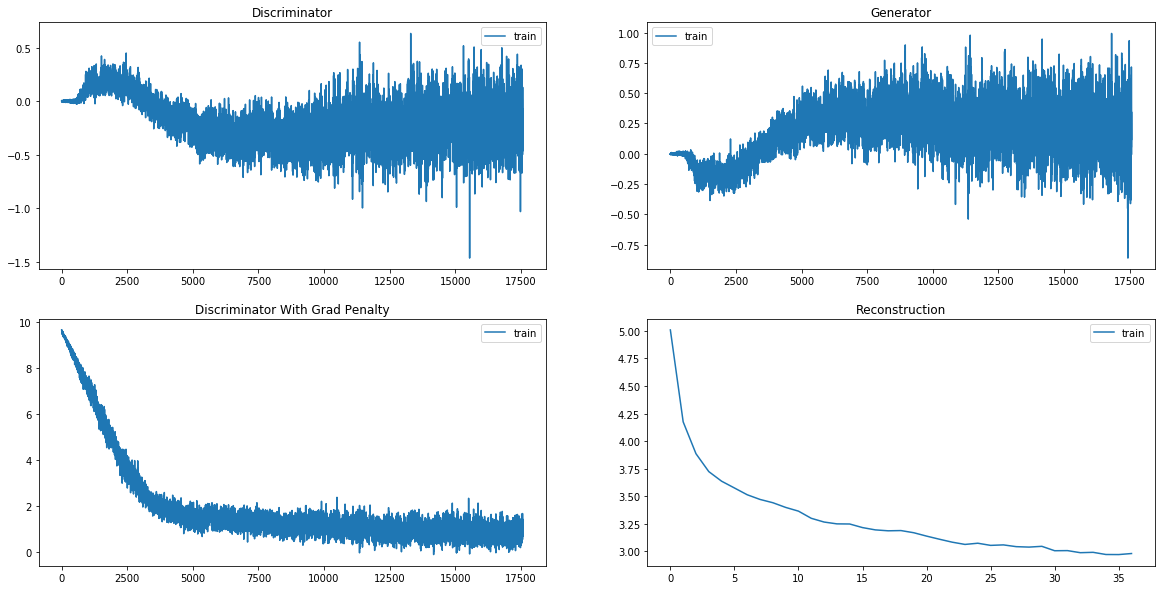

Train begins with 2374 batches with 14 left over samples

[Epcoh 38] ----------Mean Loss: 2.956273----------
Test begins with 6740 batches with 0 left over samples


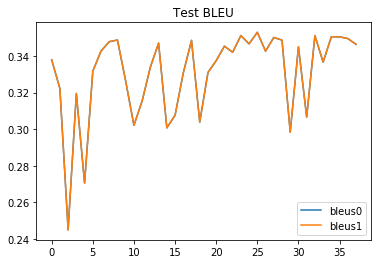

*** [Train]
*** Response
target: no ! not at all . but i
predic: i , i at all . i i </s>


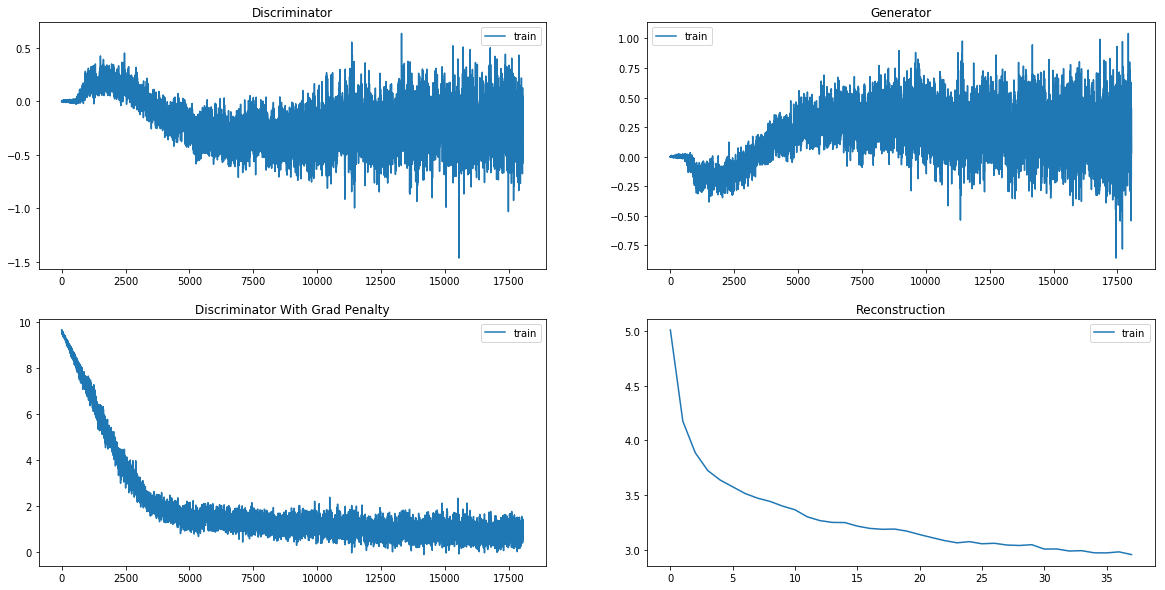

Train begins with 2374 batches with 14 left over samples

[Epcoh 39] ----------Mean Loss: 2.957294----------
Test begins with 6740 batches with 0 left over samples


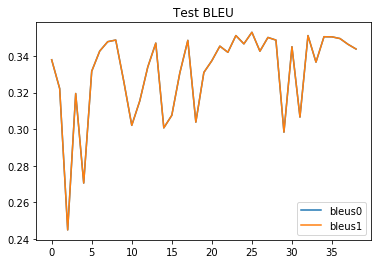

*** [Train]
*** Response
target: really ? that ' s really wonderful .
predic: i ? i ' s a a . </s>


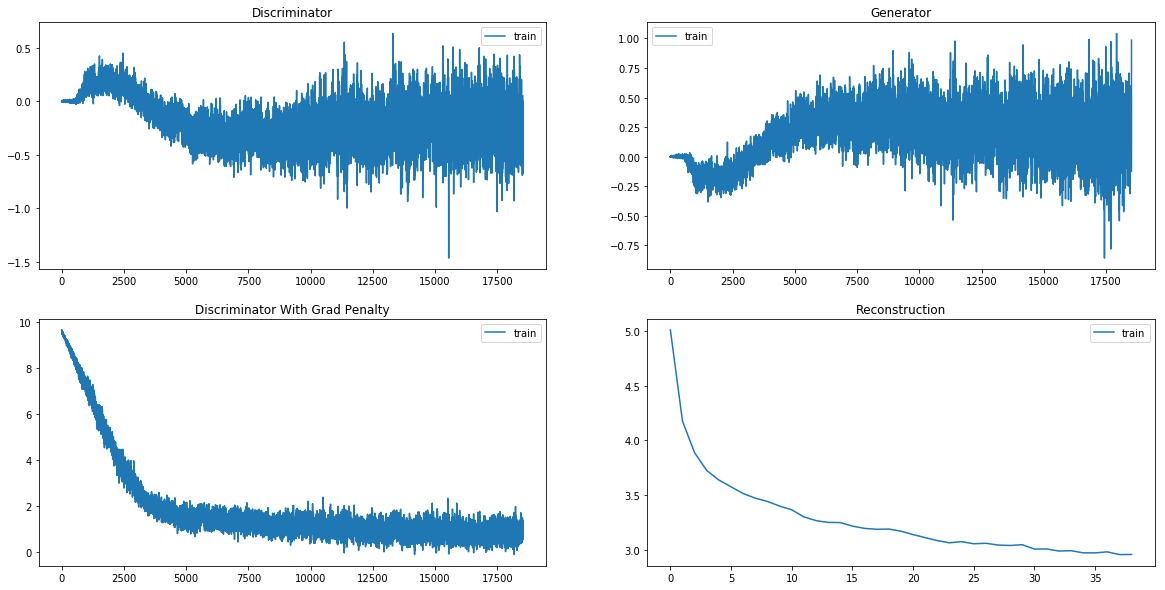

Train begins with 2374 batches with 14 left over samples

[Epcoh 40] ----------Mean Loss: 2.959881----------
Test begins with 6740 batches with 0 left over samples


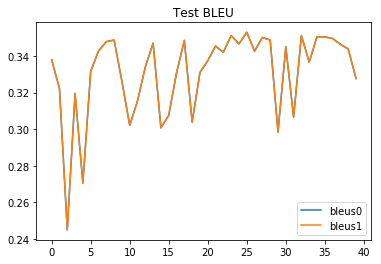

*** [Train]
*** Response
target: we also will have to check your department
predic: i ' need get an get out account </s>


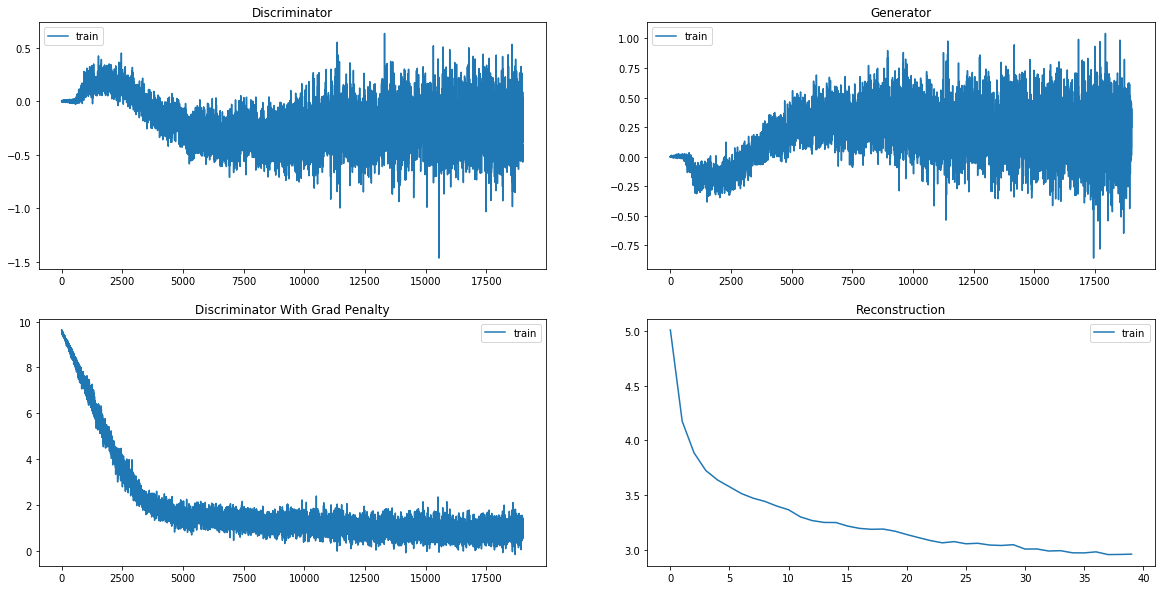

Train begins with 2374 batches with 14 left over samples

[Epcoh 41] ----------Mean Loss: 2.945231----------
Test begins with 6740 batches with 0 left over samples


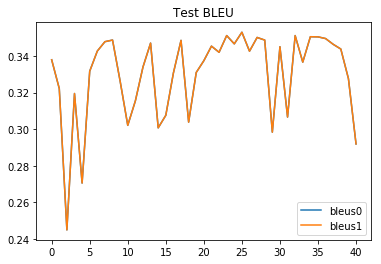

*** [Train]
*** Response
target: is it that bad ? it ’ s
predic: i there a you ? </s>


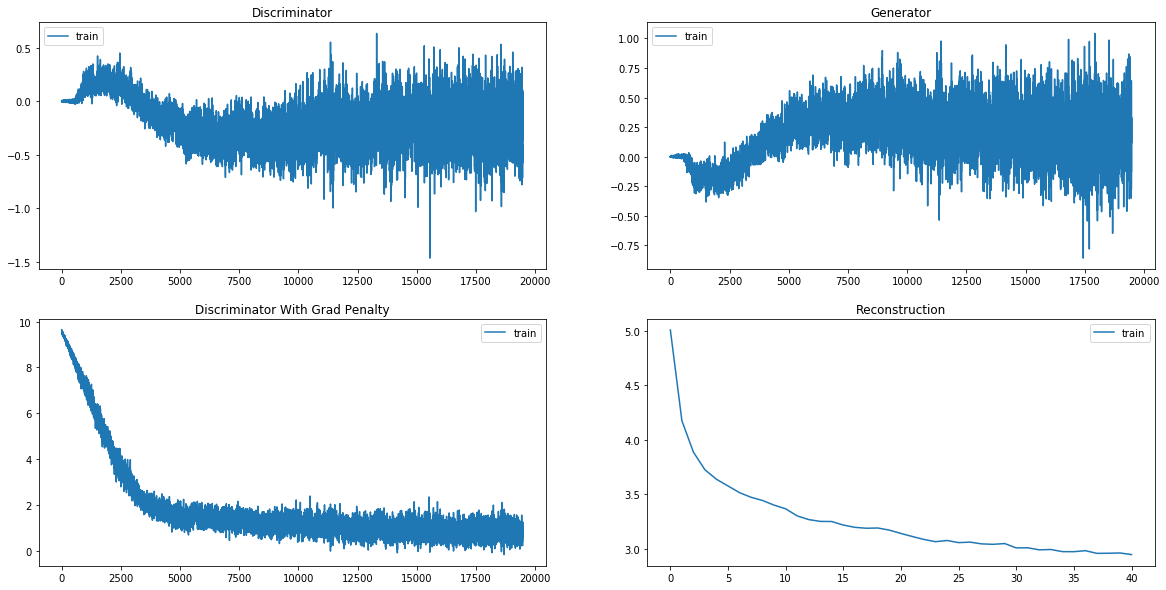

Train begins with 2374 batches with 14 left over samples

[Epcoh 42] ----------Mean Loss: 2.930477----------
Test begins with 6740 batches with 0 left over samples


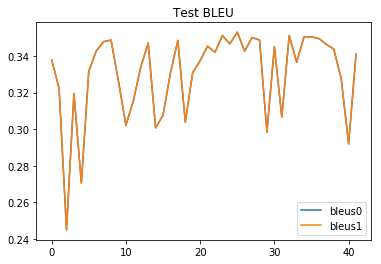

*** [Train]
*** Response
target: everything is ok now . </s>
predic: i is a . . </s>


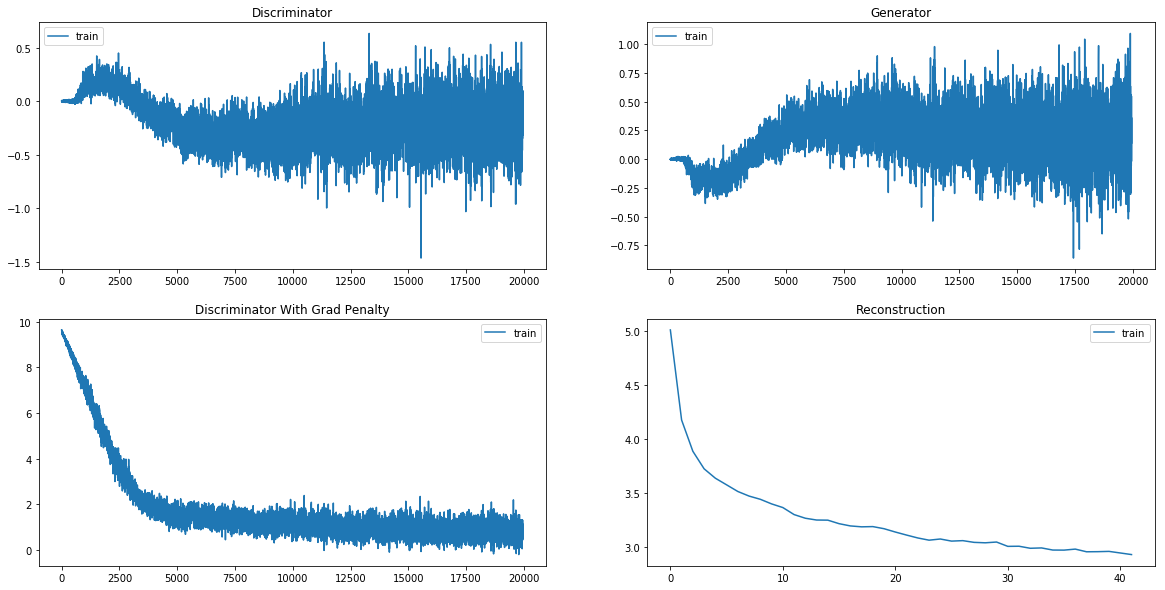

Train begins with 2374 batches with 14 left over samples

[Epcoh 43] ----------Mean Loss: 2.937380----------
Test begins with 6740 batches with 0 left over samples


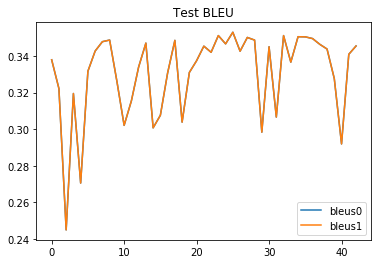

*** [Train]
*** Response
target: i called about that ad we saw in
predic: i ' the the i company ' the </s>


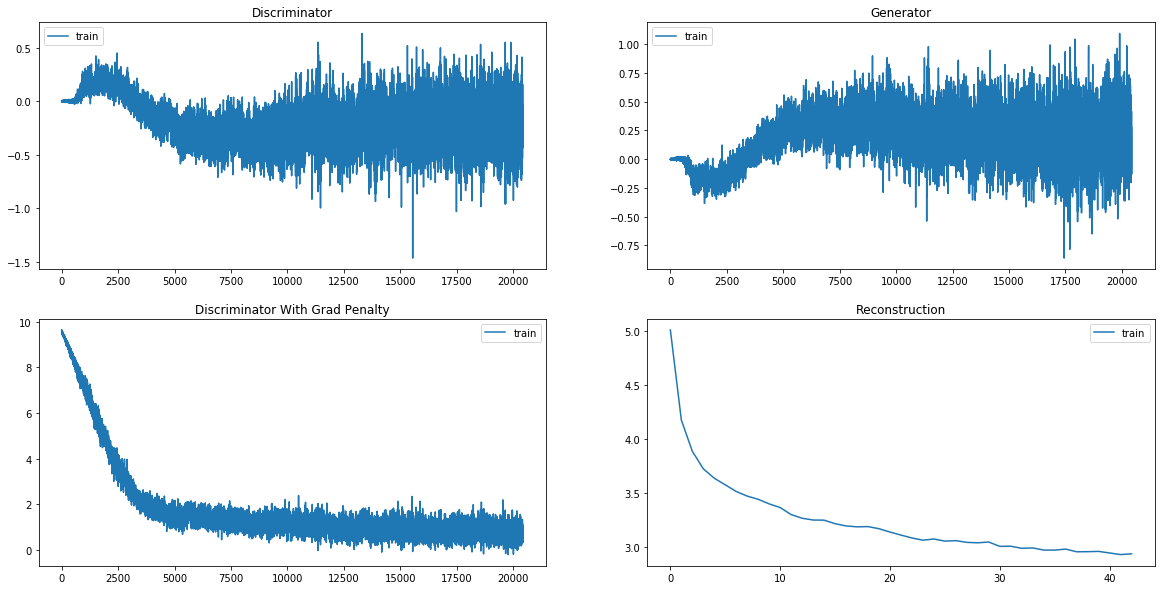

Train begins with 2374 batches with 14 left over samples

[Epcoh 44] ----------Mean Loss: 2.938982----------
Test begins with 6740 batches with 0 left over samples


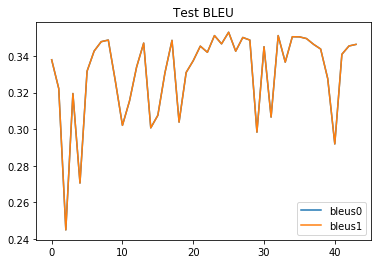

*** [Train]
*** Response
target: there aren ' t many clothes , is
predic: i are ' t many people , but </s>


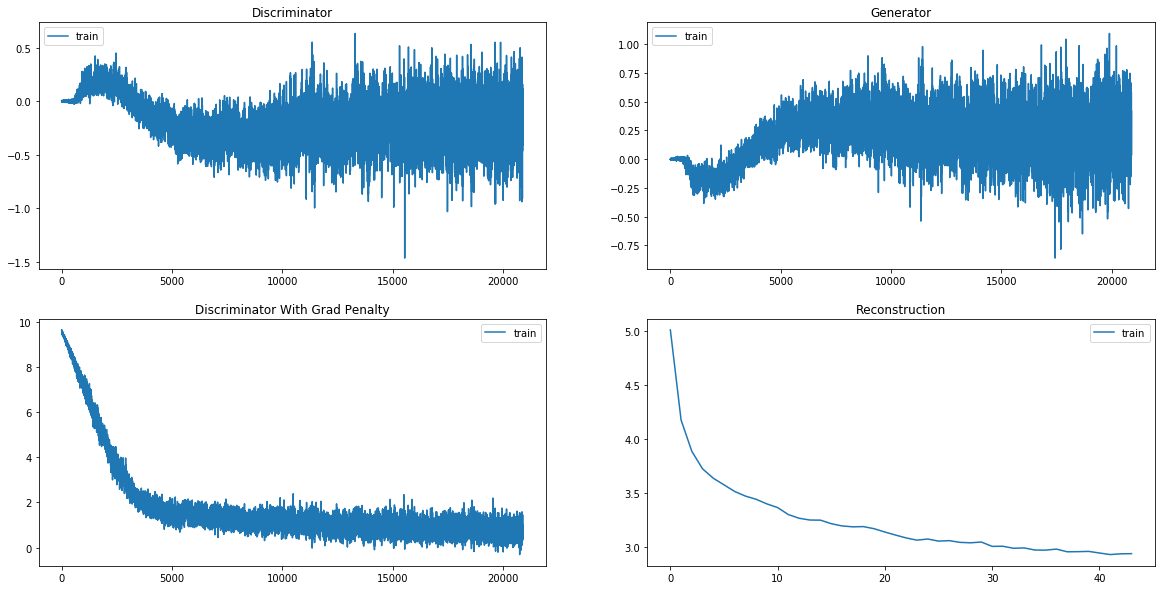

Train begins with 2374 batches with 14 left over samples

[Epcoh 45] ----------Mean Loss: 2.931233----------
Test begins with 6740 batches with 0 left over samples


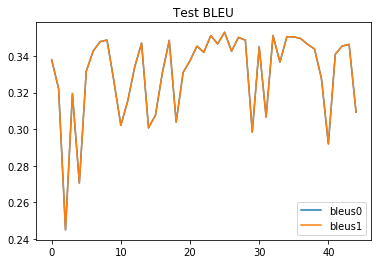

*** [Train]
*** Response
target: what happened ? </s>
predic: i is ? </s>


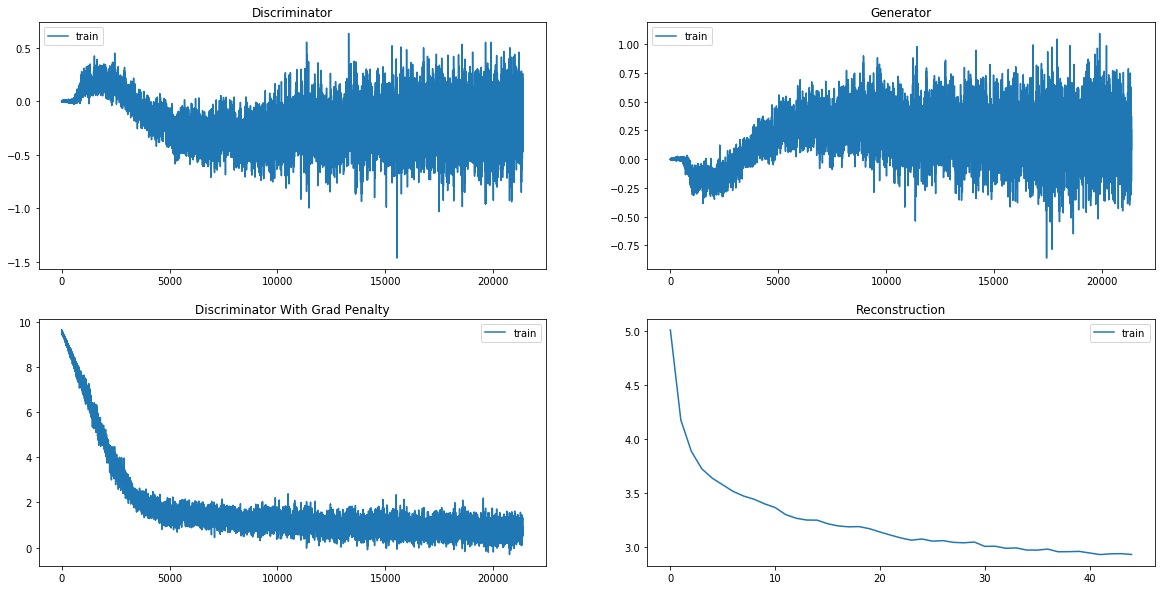

Train begins with 2374 batches with 14 left over samples

[Epcoh 46] ----------Mean Loss: 2.935621----------
Test begins with 6740 batches with 0 left over samples


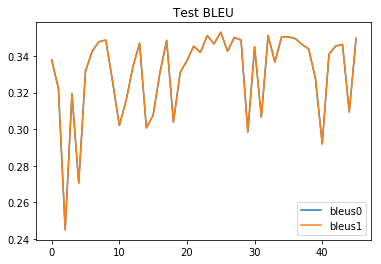

*** [Train]
*** Response
target: let ' s see if we can reach
predic: i ' s go a we can ' </s>


KeyboardInterrupt: ignored

In [0]:
class PriorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.core = nn.Sequential(nn.Linear(GRU_DIM, FC_DIM),
                                  nn.BatchNorm1d(FC_DIM),
                                  nn.Tanh(),
                                  nn.Linear(FC_DIM, FC_DIM),
                                  nn.BatchNorm1d(FC_DIM),
                                  nn.Tanh())
        self.mu_layer = nn.Linear(FC_DIM, FC_DIM)
        self.logvar_layer = nn.Linear(FC_DIM, FC_DIM)
        
    def forward(self, x):
        h = self.core(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar
        
class RecognitionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.core = nn.Sequential(nn.Linear(3*GRU_DIM, FC_DIM),
                                  nn.BatchNorm1d(FC_DIM),
                                  nn.Tanh(),
                                  nn.Linear(FC_DIM, FC_DIM),
                                  nn.BatchNorm1d(FC_DIM),
                                  nn.Tanh())
        self.mu_layer = nn.Linear(FC_DIM, FC_DIM)
        self.logvar_layer = nn.Linear(FC_DIM, FC_DIM)
        
    def forward(self, x):
        h = self.core(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

class DialogWAE(nn.Module):
    def __init__(self, train_dir, test_dir, word2vec_dir,
                 batch_size, device):
        super().__init__()
        self.batch_size = batch_size
        self.epoch = 1
        self.device = device
        
        corpus = DailyDialCorpus('DialogWAE/data/DailyDial/', VOCAB_SIZE, word2vec_dir, EMBEDDING)
        dials = corpus.get_dialogs()
        metas = corpus.get_metas()
        train_dial, valid_dial, test_dial = dials.get("train"), dials.get("valid"), dials.get("test")
        train_meta, valid_meta, test_meta = metas.get("train"), metas.get("valid"), metas.get("test")
        self.train_loader = DailyDialDataLoader("Train", train_dial, train_meta, MAX_CONTEXT)
        self.test_loader = DailyDialDataLoader("Test", test_dial, test_meta, MAX_CONTEXT)
        
        ivocab = corpus.ivocab
        self.ivocab = ivocab
        n_tokens = len(ivocab)
        self.n_tokens = n_tokens
        self.vocab = corpus.vocab

        self.embedding = nn.Embedding(n_tokens, 200, padding_idx = 0)
        self.embedding.weight.data.copy_(torch.from_numpy(corpus.word2vec))
        self.embedding.weight.data[0].fill_(0)
        self.metrics = Metrics(corpus.word2vec)
        
        self.UEnc = nn.GRU(EMBEDDING, GRU_DIM,
                           bidirectional=True, 
                           batch_first = True)
        
        self.CEnc = nn.GRU(GRU_DIM*2 + 2, GRU_DIM,
                           batch_first = True)
        
        self.Q = nn.Sequential(nn.Linear(FC_DIM, FC_DIM),
                               nn.BatchNorm1d(FC_DIM),
                               nn.ReLU(),
                               nn.Linear(FC_DIM, FC_DIM),
                               nn.BatchNorm1d(FC_DIM),
                               nn.ReLU(),
                               nn.Linear(FC_DIM, LATENT_DIM))
        
        self.G = nn.Sequential(nn.Linear(FC_DIM, FC_DIM),
                               nn.BatchNorm1d(FC_DIM),
                               nn.ReLU(),
                               nn.Linear(FC_DIM, FC_DIM),
                               nn.BatchNorm1d(FC_DIM),
                               nn.ReLU(),
                               nn.Linear(FC_DIM, LATENT_DIM))
        
        self.D = nn.Sequential(nn.Linear(FC_DIM + GRU_DIM, FC_DIM_D),
                               nn.BatchNorm1d(FC_DIM_D),
#                              nn.ReLU(),
                               nn.LeakyReLU(0.2),
                               nn.Linear(FC_DIM_D, FC_DIM_D),
                               nn.BatchNorm1d(FC_DIM_D),
                               nn.LeakyReLU(0.2),
#                              nn.ReLU(),
                               nn.Linear(FC_DIM_D, 1))
        self.PriNet = PriorNet()
        self.RecNet = RecognitionNet()
        self.Dec = nn.GRU(EMBEDDING, LATENT_DIM + GRU_DIM,
                          batch_first = True)
        self.dec_projector = nn.Linear(LATENT_DIM + GRU_DIM, n_tokens)
        self.init_weights()
        nn.init.uniform_(self.dec_projector.weight, -0.1, 0.1)

        self.optimizer_gen = optim.RMSprop(list(self.Q.parameters()) \
                                           +list(self.G.parameters()) \
                                           +list(self.PriNet.parameters()) \
                                           +list(self.RecNet.parameters()), LR_GEN)
        
        self.optimizer_discriminator = optim.RMSprop(self.D.parameters(), LR_DISC)
        
        self.encoder = nn.ModuleList([self.embedding,
                                 self.UEnc,
                                 self.CEnc])
        self.decoder = nn.ModuleList([self.embedding,
                                 self.Dec,
                                 self.dec_projector])
        
        self.optimizer_reconstruction = optim.SGD(list(self.encoder.parameters()) \
                                                  +list(self.RecNet.parameters()) \
                                                  +list(self.Q.parameters()) \
                                                  +list(self.decoder.parameters()),
                                                  LR_RECON)
        self.lr_decay = optim.lr_scheduler.StepLR(self.optimizer_reconstruction,
                                                  10, 0.6)


        
    def init_weights(self):
        for layer in self.modules():
            if type(layer) == nn.Linear:
                nn.init.uniform_(layer.weight, -INIT_SCALE, INIT_SCALE)
                layer.bias.data.fill_(0)
            elif type(layer) == nn.GRU:
                for w in layer.parameters(): 
                    if w.dim()>1:
                        nn.init.orthogonal_(w)
    
    def init_word2vec(self, word2vec_dir):
        if word2vec_dir:
            SIZE = 1.2 * 10**6
            found = 0
            word2vec_pretrained = torch.randn(VOCAB_SIZE,200)
            word2vec_pretrained[self.data.PAD] = torch.zeros(200)
            with open(word2vec_dir, 'r') as f:
                for entry in f:
                    entry = entry.strip().split(" ")
                    if entry[0] in self.data.vocab['word_to_num']:
                        idx = self.data.vocab['word_to_num'][entry[0]]
                        word2vec_pretrained[idx] = torch.tensor(list(map(float, entry[1:])))
                        found += 1
                    if found == VOCAB_SIZE:
                        break
                print("Done Initializing Word2Vec (found %d/%d)" %(found, VOCAB_SIZE))
            return nn.Embedding.from_pretrained(word2vec_pretrained, freeze=False)
        else:
            return nn.Embedding(VOCAB_SIZE, 200, padding_idx = self.data.PAD)

    def forward(self, X, Xlen):
        c = self.encode_c(X, Xlen)

        eps_prior = self.sample_prior(c)
        z_prior = self.G(eps_prior)
        
        init_state = torch.unsqueeze(torch.cat((z_prior, c), 1), 0)
            
        return self.decode(None, init_state)
        
        
    
    def discriminator_loss(self, z_prior, z_posterior, c):
        prior_input = torch.cat((z_prior, c), -1)
        posterior_input = torch.cat((z_posterior, c), -1)
        
        d_prior = self.D(prior_input)
        d_posterior = self.D(posterior_input)
        
        loss = torch.mean(d_posterior) - torch.mean(d_prior)
        return loss
    
    def gradient_penalty(self, z_prior, z_posterior, c):
        batch_size = c.size(0)
        alpha = torch.rand((batch_size, 1)).to(self.device)
        
        alpha = alpha.expand(z_prior.size())
        interpolates = alpha * z_prior.data + (1-alpha) * z_posterior.data
        interpolates.requires_grad = True
        
        d_interpolates = torch.mean(self.D(torch.cat((interpolates, c), -1)))
        
        grad_outputs = torch.FloatTensor([1]).to(device)
        grad = autograd.grad(d_interpolates, interpolates,
                            grad_outputs = grad_outputs,
                            only_inputs = True, create_graph = True,
                            retain_graph=True)[0]
        grad_norm = torch.norm(grad, p = 2, dim = 1)
        
        penalty = (grad_norm - 1) ** 2
        return torch.mean(penalty)
    
    def reconstruction_loss(self, pred, target):
        target = target.contiguous().view(-1)
        mask = [idx for idx, val in enumerate(target) if val != 0]
        mask = torch.tensor(mask).to(self.device)
        pred = F.log_softmax(pred, -1).view(-1, self.n_tokens)
        pred = torch.index_select(pred, 0, mask)
        target = torch.index_select(target, 0, mask)
        loss = F.nll_loss(pred, target)
        return loss
    
    def combine_context(self, X, lengths, X_raw):
        batch_size = len(lengths)
        context_window = max(lengths)
        LISTENER_VECTOR = [1,0]
        SPEAKER_VECTOR = [0,1]
        speaker_first = [SPEAKER_VECTOR if i%2==0 else LISTENER_VECTOR
                         for i in range(context_window)]
        listener_first = [LISTENER_VECTOR if i%2==0 else SPEAKER_VECTOR
                          for i in range(context_window)]
        floors = []        
        new_X = list()
        offset = 0
        for length in lengths:
            segment = X[offset:offset+length]
            floor = speaker_first if length%2==0 else listener_first
            if X_raw[offset][1] == self.ivocab['<d>']:
                floor[0] = LISTENER_VECTOR
            floors.append(floor)
            segment_len, dim = segment.shape
            segment_padded = torch.cat((segment,
                                      torch.randn(context_window - segment_len, dim)\
                                        .to(self.device)))
            new_X.append(segment_padded)
            offset += length
        X = torch.stack(new_X, 0)
        floors = torch.tensor(floors, dtype=torch.float).to(self.device)
        
        return torch.cat((X, floors), 2)
        
    def encode_x(self, Y, Ylen):
        Ylen_sorted, ids = torch.sort(Ylen, descending=True)
        _, ids_reverse = torch.sort(ids, descending=False)
        Y_sorted = torch.index_select(Y, 0, ids)
        Y_sorted = Y_sorted[:,1:]
        Ylen_sorted -= 1
        Y_embed = self.embedding(Y_sorted)
        #Dropout
        Y_embed = F.dropout(Y_embed, p=0.5, training=self.encoder.training)
        Y_packed = pack_padded_sequence(Y_embed,
                                       Ylen_sorted,
                                       batch_first = True)
        
        _, res = self.UEnc(Y_packed)
        Y_encoded = torch.cat([res[0], res[1]], dim=1)
        Y_ordered = torch.index_select(Y_encoded, 0, ids_reverse)
        return Y_ordered
        
    def encode_c(self, X, Xlen):
        original_size = X.size()
        batch_size = original_size[0]
        
        real_utts = torch.tensor([i for i,x in enumerate(Xlen) if x > 0]).to(self.device)
        X_real = torch.index_select(X.view(-1, original_size[-1]),
                                   0,
                                   real_utts)
        Xlen_real = torch.index_select(Xlen, 0, real_utts)

        Xlen_sorted, ids = torch.sort(Xlen_real, descending=True)
        _, ids_reverse = torch.sort(ids, descending=False)
        X_sorted = torch.index_select(X_real, 0, ids)
        X_sorted = X_sorted[:,1:]
        Xlen_sorted -= 1
        
        X_embed = self.embedding(X_sorted)
        #Dropout
        X_embed = F.dropout(X_embed, p=0.5, training=self.encoder.training)
        X_packed = pack_padded_sequence(X_embed,
                                        Xlen_sorted,
                                        batch_first=True)
        _, res = self.UEnc(X_packed)
        X_encoded = torch.cat([res[0], res[1]], dim=1)
        X_ordered = torch.index_select(X_encoded, 0, ids_reverse)

        context_lengths = torch.sum(Xlen.view(original_size[:-1])>0, 1)
        X_contexts = self.combine_context(X_ordered, context_lengths, X_real) 
        
        #Dropout
        X_contexts = F.dropout(X_contexts, p=0.25, training=self.encoder.training)


        Clen_sorted, ids = torch.sort(context_lengths, descending=True)
        _, ids_reverse = torch.sort(ids, descending=False)
        C_sorted = torch.index_select(X_contexts, 0, ids)


        C_packed = pack_padded_sequence(C_sorted,
                                        Clen_sorted, 
                                        batch_first = True)
        _, C_encoded = self.CEnc(C_packed)
        
        C_ordered = torch.index_select(torch.squeeze(C_encoded, 0),
                                      0,
                                      ids_reverse)
        return C_ordered
    
    def sample_prior(self, c):
        batch_size = c.size(0)
        mu, logvar = self.PriNet(c)
        stddev = torch.exp(0.5*logvar)
        noise = torch.randn((batch_size, LATENT_DIM)).to(self.device)
        return stddev * noise + mu
        
    def sample_posterior(self, x, c):
        batch_size = c.size(0)
        xc = torch.cat((x,c), 1)
        mu, logvar = self.RecNet(xc)
        stddev = torch.exp(0.5*logvar)
        noise = torch.randn((batch_size, LATENT_DIM)).to(self.device)
        return stddev * noise + mu
    
    def decode(self, decoder_input, init_state):
        if decoder_input:
            res, _ = self.Dec(decoder_input, init_state)
            return res
        else:
            # Dynamic decoding
            batch_size = init_state.size(1)
            decoder_input = torch.full((batch_size, 1), self.ivocab["<s>"],
                                      dtype=torch.long).to(self.device)
            h = init_state
            decoder_output = list()
            decoder_output_lengths = torch.zeros(batch_size).to(self.device)
            for i in range(MAX_UTT):
                decoder_input = self.embedding(decoder_input)
                out, h = self.Dec(decoder_input, h)
                out = self.dec_projector(out)
                
                pred = torch.argmax(out, -1)
                decoder_output.append(out)
                
                ended = pred == self.ivocab['</s>']
                running = decoder_output_lengths == 0
                new_ended = ended.view(-1) * running
                ids = [idx for idx, v in enumerate(new_ended) if v > 0]
                decoder_output_lengths[ids] = i + 1
                decoder_input = pred
                
            not_ended = decoder_output_lengths == 0
            ids = [idx for idx, v in enumerate(not_ended) if v > 0]
            decoder_output_lengths[ids] = MAX_UTT
            
            decoder_output = torch.cat(decoder_output, 1)
            return decoder_output, decoder_output_lengths
            
    
    def disc_step(self, batch):
        self.optimizer_discriminator.zero_grad()
#         X, Xlen, Y, Ylen = batch
#         X = X.to(self.device)
#         Xlen = Xlen.to(self.device)
#         Y = Y.to(self.device)
#         Ylen = Ylen.to(self.device)
        X, context_lens, Xlen, floors,_,_,_,Y,Ylen,_ = batch
        X = torch.from_numpy(X).to(self.device)
        Xlen = torch.from_numpy(Xlen).view(-1).to(self.device)
        Y = torch.from_numpy(Y).to(self.device)
        Ylen = torch.from_numpy(Ylen).to(self.device)
        
        c = self.encode_c(X, Xlen)
        x = self.encode_x(Y, Ylen)
        
        eps_prior = self.sample_prior(c)
        eps_posterior = self.sample_posterior(x, c)

        z_prior = self.G(eps_prior)
        z_posterior = self.Q(eps_posterior)
        
        disc_loss = self.discriminator_loss(z_prior.detach(), z_posterior.detach(), c.detach())
#         disc_loss.backward()
        grad_penalty = self.gradient_penalty(z_prior, z_posterior, c.detach())
        loss = disc_loss + LAMBDA_D * grad_penalty
        
        loss.backward()
        self.optimizer_discriminator.step()
        return loss, disc_loss
    
    def fit(self, epochs, test_every):
        loss_recon_train = []
        loss_disc_train = []
        loss_disc_with_grad_train = []
        loss_gen_train = []
        bleus0, bleus1 = [], []
        for _ in range(epochs):
            self.train()
            loss_recon_epoch = []
            self.train_loader.epoch_init(32, MAX_UTT, 1, shuffle=True)
            batch = self.train_loader.next_batch()
            while batch:
                #setup
#                 X, Xlen, Y, Ylen = batch
#                 X = X.to(self.device)
#                 Xlen = Xlen.to(self.device)
#                 Y = Y.to(self.device)
#                 Ylen = Ylen.to(self.device)
                X, context_lens, Xlen, floors,_,_,_,Y,Ylen,_ = batch
                X = torch.from_numpy(X).to(self.device)
                Xlen = torch.from_numpy(Xlen).view(-1).to(self.device)
                Y = torch.from_numpy(Y).to(self.device)
                Ylen = torch.from_numpy(Ylen).to(self.device)
    
                
                #optimize reconstruction
                self.optimizer_reconstruction.zero_grad()
                self.encoder.train()
                self.decoder.train()

                c = self.encode_c(X, Xlen)
                x = self.encode_x(Y, Ylen)
                
                eps_posterior = self.sample_posterior(x, c)
                z_posterior = self.Q(eps_posterior)
                
                init_state = torch.unsqueeze(torch.cat((z_posterior, c), 1), 0)
                
                targets = Y[:,:-1]
                targetslen = Ylen - 1
                targetslen_sorted, ids = torch.sort(targetslen, descending=True)
                _, ids_reverse = torch.sort(ids, descending=False)
                targets_sorted = torch.index_select(targets, 0, ids)
                targets_embed = self.embedding(targets_sorted)
                #Dropout
                targets_embed = F.dropout(targets_embed, p=0.5,
                                          training=self.decoder.training)
                decoder_input = pack_padded_sequence(targets_embed,
                                                    targetslen_sorted,
                                                    batch_first = True)
                
                pred_packed = self.decode(decoder_input, init_state)
                pred, _ = pad_packed_sequence(pred_packed,
                                             batch_first=True)
                pred = torch.index_select(pred, 0, ids_reverse)
                pred = self.dec_projector(pred)
                reconstruction_loss = self.reconstruction_loss(pred, Y[:,1:])
                
                loss_recon_epoch.append(reconstruction_loss.item())
                reconstruction_loss.backward()
                clip_grad_norm_(list(self.encoder.parameters())
                                +list(self.decoder.parameters()), MAX_NORM)
                self.optimizer_reconstruction.step()
                #optimize generator
                self.encoder.eval()
                for p in self.D.parameters():
                    p.requires_grad = False
                self.optimizer_gen.zero_grad()

                c = self.encode_c(X, Xlen)
                x = self.encode_x(Y, Ylen)
                
                eps_prior = self.sample_prior(c.detach())
                eps_posterior = self.sample_posterior(x.detach(), c.detach())
                
                z_prior = self.G(eps_prior)
                z_posterior = self.Q(eps_posterior)
                
                gen_loss = -1 * self.discriminator_loss(z_prior, z_posterior, c.detach())
                loss_gen_train.append(gen_loss.item())
                gen_loss.backward()

                self.optimizer_gen.step()
                for p in self.D.parameters():
                    p.requires_grad = True

                #optimize discriminator
                self.encoder.eval()
                self.D.train()
                for _ in range(N_CRITIC):
                    loss_with_grad, loss = self.disc_step(batch)
                    batch = self.train_loader.next_batch()
                    if not batch:
                        break
                loss_disc_with_grad_train.append(loss_with_grad.detach())
                loss_disc_train.append(loss.item())
                
            self.lr_decay.step()
                
            loss_recon_train.append(mean(loss_recon_epoch))
            print("\n[Epcoh %d] ----------Mean Loss: %f----------"%(self.epoch, loss_recon_train[-1]))
            if self.epoch % test_every == 0:
                bleu0, bleu1 = self.test()
                bleus0.append(bleu0)
                bleus1.append(bleu1)
                if len(bleus0) > 1:
                    plt.plot(bleus0, label='bleus0')
                    plt.plot(bleus1, label='bleus1')
                    plt.title(label='Test BLEU')
                    plt.legend()
                    plt.show()
            ckpt_name = 'checkpoints/model' + str(self.epoch) + '.pkl'
            self.epoch += 1
            torch.save(self, ckpt_name)
            copyfile(ckpt_name, 'checkpoints/model.pkl')
            
            print("*** [Train]")
#             print("*** Context")
#             for utt in X[0]:
#                 x = to_string(self.data.to_text(utt.tolist()))
#                 if len(x) > 0:
#                     print(x)
            print("*** Response")
            x = torch.argmax(pred, -1)
            print('target:', indexes2sent(targets[0,1:].cpu().numpy(), self.ivocab, self.ivocab["</s>"], 0)[0])
            print('predic:', indexes2sent(x[0].cpu().numpy(), self.ivocab, self.ivocab["</s>"], self.ivocab["<s>"])[0])
            if self.epoch > 2:
                plt.figure(figsize=(20,10))
                plt.subplot(221)
                plt.plot(loss_disc_train, label='train')
                plt.title(label='Discriminator')
                plt.legend()
                plt.subplot(222)
                plt.plot(loss_gen_train, label='train')
                plt.title(label='Generator')
                plt.legend()
                plt.subplot(223)
                plt.plot(loss_disc_with_grad_train, label='train')
                plt.title(label='Discriminator With Grad Penalty')
                plt.legend()
                plt.subplot(224)
                plt.plot(loss_recon_train, label='train')
                plt.title(label='Reconstruction')
                plt.legend()
                plt.show()
            
    def test(self):
        self.eval()
        self.encoder.eval()
        self.decoder.eval()
        bleu0 = []
        bleu1 = []
        self.test_loader.epoch_init(1, MAX_UTT, 1, shuffle=False)
        sample = self.test_loader.next_batch()
        while sample:
            X, context_lens, Xlen, floors,_,_,_,Y,Ylen,_ = sample
            x = torch.from_numpy(X).to(self.device)
            xlen = torch.from_numpy(Xlen).view(-1).to(self.device)
            y = torch.from_numpy(Y).to(self.device)
            ylen = torch.from_numpy(Ylen).to(self.device)
            pred, predlen = self(x, xlen)
            pred = torch.argmax(pred, -1)
            pred,_ = indexes2sent(pred[0].cpu().numpy(), self.ivocab,  self.ivocab["</s>"], 0)
            pred = [pred.split(' ')]
            predlen = int(predlen.item())
            target,_ = indexes2sent(y[0].cpu().numpy(),  self.ivocab,  self.ivocab["</s>"],  self.ivocab["<s>"])
            target = target.split(' ')
            bleu = self.metrics.sim_bleu(pred, target)
            bleu0.append(bleu[0])
            bleu1.append(bleu[1])
            sample = self.test_loader.next_batch()
#         print("*** [Test]")
#         print("*** Context")
#         for utt in x[0]:
#             x = to_string(self.data.to_text(utt.tolist()))
#             if len(x) > 0:
#                 print(x)
#         print("*** Response")
#         x = torch.argmax(pred, -1)
#         print('target:', to_string(self.data.to_text(target[0].tolist())))
#         print('predic:', to_string(self.data.to_text(x[0].tolist())))
        return mean(bleu0), mean(bleu1)
            
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.manual_seed(1111)
# model = DialogWAE('train/dialogues_train.txt',
#                   'test/dialogues_test.txt',
#                   None,
#                   32,
#                   device).to(device)
model = DialogWAE('train/dialogues_train.txt',
                  'test/dialogues_test.txt',
                  'glove.twitter.27B.200d.txt',
                  32,
                  device).to(device)
# model = torch.load('checkpoints/model.pkl').to(device)
model.fit(100, 1)

In [0]:
corpus = DailyDialCorpus('DialogWAE/data/DailyDial/', VOCAB_SIZE, 'glove.twitter.27B.200d.txt', EMBEDDING)
dials = corpus.get_dialogs()
metas = corpus.get_metas()
train_dial, valid_dial, test_dial = dials.get("train"), dials.get("valid"), dials.get("test")
train_meta, valid_meta, test_meta = metas.get("train"), metas.get("valid"), metas.get("test")
train_loader = DailyDialDataLoader("Train", train_dial, train_meta, MAX_CONTEXT)
test_loader = DailyDialDataLoader("Test", test_dial, test_meta, MAX_CONTEXT)
ivocab = corpus.ivocab
ivocab = ivocab
vocab = corpus.vocab

train_loader.epoch_init(32, MAX_UTT, 1, shuffle=True)

Max utt len 296, mean utt len 16.48
Max utt len 174, mean utt len 16.37
Max utt len 214, mean utt len 16.68
Load corpus with train size 2, valid size 2, test size 2 raw vocab size 17716 vocab size 10000 at cut_off 2 OOV rate 0.006757
<d> index 21
<sil> index -1
word2vec cannot cover 0.032194 vocab
Done loading corpus
Max len 36 and min len 3 and avg len 8.840439
Max len 27 and min len 3 and avg len 8.740000
Train begins with 2374 batches with 14 left over samples


In [0]:
batch = train_loader.next_batch()
X, context_lens, Xlen, floors,_,_,_,Y,Ylen,_ = batch
X = torch.from_numpy(X)
Xlen = torch.from_numpy(Xlen).view(-1)
Y = torch.from_numpy(Y)
Ylen = torch.from_numpy(Ylen)

In [0]:
model = torch.load('checkpoints/model.pkl').to("cuda:0")

In [0]:
model.test_loader.epoch_init(1, MAX_UTT, 1, shuffle=False)
sample = model.test_loader.next_batch()

Test begins with 6740 batches with 0 left over samples


In [0]:
X, context_lens, Xlen, floors,_,_,_,Y,Ylen,_ = sample
x = torch.from_numpy(X).to(model.device)
xlen = torch.from_numpy(Xlen).view(-1).to(model.device)
y = torch.from_numpy(Y).to(model.device)
ylen = torch.from_numpy(Ylen).to(model.device)
pred, predlen = model(x, xlen)
pred = torch.argmax(pred, -1)
pred,_ = indexes2sent(pred[0].cpu().numpy(), model.ivocab,  model.ivocab["</s>"], 0)
pred = [pred.split(' ')]
predlen = int(predlen.item())
target,_ = indexes2sent(y[0].cpu().numpy(),  model.ivocab,  model.ivocab["</s>"],  model.ivocab["<s>"])
target = target.split(' ')
# bleu = model.metrics.sim_bleu(pred, target)

In [0]:
pred

[['i', "'", 'm', 'going', 'to', 'the', 'concert', 'of', '</s>']]

In [0]:
!ls checkpoints